Pour une lecture améliorée, ce notebook est idéalement lu avec une extension qui gère les niveaux des titres Markdown.  
Par exemple avec l'extension 'Table of Contents' du module 'Nbextensions' de Jupyter.

# Mise en place du notebook

## Import des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import preprocessing
from mesfonctions import scatter_plot
from mesfonctions import display_scree_plot
from mesfonctions import display_circles

In [2]:
# pour développement
import mesfonctions
from importlib import reload  
mesfonctions = reload(mesfonctions)

## Gestion des paramètres d'affichage de Jupyter

In [3]:
# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

# pour gérer l'affichage des arrays numpy
# 230 sur ma config bureau, 165 sur ma config portable
np.set_printoptions(linewidth=230)

# pour afficher les gros fichiers sur toute la largeur de l'écran
from IPython.core.display import HTML
HTML("<style>.container { width:95% }</style>")

# Notes

Gross floor area (GFA) - The total floor area contained within the building measured to the external face of the external walls. Mesuré en square feet.  

1 sq foot = 0.092 m²  

ENERGYSTARScore : score de 1 à 100. Le score correspond au centile dans lequel le bâtiment se trouve.  
EPA relies on source EUI as the basis for the ENERGY STAR score.  
SourceEUI = énergie primaire (produite, à acheminer). SourceEUI = énergie secondaire (utilisée par le bâtiment).  
The score evaluates a building relative to its peers, similar to the median energy use values, and also adjusts for climate and business activity.  

Property Types. The ENERGY STAR score for data centers applies to spaces specifically designed and equipped to meet the needs of high density computing equipment such as server racks, used for data storage and processing. The score applies to individual buildings only and is not available for campuses.  
L'ENERGYSTARScore n'est pas adapté pour les bâtiments à plusieurs usages (qui sont la base du dataset de Seattle) car il ne considère que l'usage principal du bâtiment. Le nb de paramètres en entrée est différent pour chaque type de bâtiment (data center, hôpital, ...) et est assez élevé pour différencier les usages d'un bâtiment donné.
Globalement, l'EnergyStarScore est plus pointu que les données du dataset de Seattle.


Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area.  

1 acre = 4047 m²  

1 British thermal unit (kBtu) per square foot = 3.2 kW.h/m²  

1 kBtu = 0.29 kW.h  

SPD beats : rondes de la police (SPD = Seattle PD)

WN : weather normalized. Site Energy Use the property would have consumed during 30-year average weather conditions.

TotalGHGEmissions : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. 

# Récupération des données pour 2015 et 2016

## Lecture des fichiers .json (metadata)

### Fichier pour 2015

#### Affichage intégral du json :

In [4]:
with open('socrata_metadata_2015-building-energy-benchmarking.json') as f:
  df2015metadata = json.load(f)
print(json.dumps(df2015metadata, indent = 4, sort_keys=False))

{
    "id": "h7rm-fz6m",
    "name": "2015 Building Energy Benchmarking",
    "assetType": "dataset",
    "attribution": "City of Seattle",
    "attributionLink": "http://www.seattle.gov/environment",
    "averageRating": 0,
    "createdAt": 1492461362,
    "description": "Seattle\u2019s Building Energy Benchmarking and Reporting Program (SMC 22.920) requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings. In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.\r\nPer Ordinance (125000), starting 

Sections du json :

In [5]:
df2015metadata.keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'attributionLink', 'averageRating', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'licenseId', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'license', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

#### Affichage intégral de la section "columns" :

In [6]:
nbcol = len(df2015metadata["columns"])
print("Nb de colonnes :", nbcol)

Nb de colonnes : 47


In [7]:
for column in range(len(df2015metadata["columns"])):
    print(f"********** Colonne {column} **********")
    print(df2015metadata["columns"][column])
    print()

********** Colonne 0 **********
{'id': 350402298, 'name': 'OSEBuildingID', 'dataTypeName': 'number', 'description': 'A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.', 'fieldName': 'seattlebuildingid', 'position': 1, 'renderTypeName': 'number', 'tableColumnId': 46302822, 'width': 182, 'cachedContents': {'largest': '50059', 'non_null': 3340, 'average': '20522.16826347305', 'null': '0', 'top': [{'item': '2', 'count': '1'}, {'item': '3', 'count': '1'}, {'item': '5', 'count': '1'}, {'item': '8', 'count': '1'}, {'item': '9', 'count': '1'}, {'item': '10', 'count': '1'}, {'item': '11', 'count': '1'}, {'item': '12', 'count': '1'}, {'item': '13', 'count': '1'}, {'item': '15', 'count': '1'}, {'item': '16', 'count': '1'}, {'item': '17', 'count': '1'}, {'item': '18', 'count': '1'}, {'item': '19', 'count': '1'}, {'item': '21', 'count': '1'}, {'item': '22', 'count': '1'}, {'item': '23', 'count': '1'}, {'item': '24',

#### Affichage simplifié de la section "columns" :

In [8]:
liste_var_2015 = []
for column in range(nbcol):
    name = df2015metadata["columns"][column]['name']
    liste_var_2015.append(name)
    print(f"********** Colonne {column} : {name} **********")
    try :
        print(df2015metadata["columns"][column]['description'])
    except :
        print("Description non disponible")

********** Colonne 0 : OSEBuildingID **********
A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
********** Colonne 1 : DataYear **********
Description non disponible
********** Colonne 2 : BuildingType **********
City of Seattle building type classification.
********** Colonne 3 : PrimaryPropertyType **********
The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
********** Colonne 4 : PropertyName **********
Official or common property name.
********** Colonne 5 : TaxParcelIdentificationNumber **********
	
Property King County PIN
********** Colonne 6 : Location **********
Description non disponible
********** Colonne 7 : CouncilDistrictCode **********
Property City of Seattle council district.
********** Colonne 8 : Neighborhood **********

### Fichier pour 2016

#### Affichage intégral du json :

In [9]:
with open('socrata_metadata_2016-building-energy-benchmarking.json') as f:
  df2016metadata = json.load(f)
print(json.dumps(df2016metadata, indent = 4, sort_keys=False))

{
    "id": "2bpz-gwpy",
    "name": "2016 Building Energy Benchmarking",
    "assetType": "dataset",
    "attribution": "City of Seattle",
    "attributionLink": "https://www.seattle.gov/energybenchmarking",
    "averageRating": 0,
    "createdAt": 1521070051,
    "description": "Seattle\u2019s Building Energy Benchmarking and Reporting Program (SMC 22.920) requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings. In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.\nPer Ordinance (125000), sta

Sections du json :

In [10]:
df2016metadata.keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'attributionLink', 'averageRating', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'licenseId', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowIdentifierColumnId', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'license', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

#### Affichage intégral de la section "columns" :

In [11]:
nbcol = len(df2016metadata["columns"])
print("Nb de colonnes :", nbcol)

Nb de colonnes : 46


In [12]:
for column in range(len(df2016metadata["columns"])):
    print(f"********** Colonne {column} **********")
    print(df2015metadata["columns"][column])
    print()

********** Colonne 0 **********
{'id': 350402298, 'name': 'OSEBuildingID', 'dataTypeName': 'number', 'description': 'A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.', 'fieldName': 'seattlebuildingid', 'position': 1, 'renderTypeName': 'number', 'tableColumnId': 46302822, 'width': 182, 'cachedContents': {'largest': '50059', 'non_null': 3340, 'average': '20522.16826347305', 'null': '0', 'top': [{'item': '2', 'count': '1'}, {'item': '3', 'count': '1'}, {'item': '5', 'count': '1'}, {'item': '8', 'count': '1'}, {'item': '9', 'count': '1'}, {'item': '10', 'count': '1'}, {'item': '11', 'count': '1'}, {'item': '12', 'count': '1'}, {'item': '13', 'count': '1'}, {'item': '15', 'count': '1'}, {'item': '16', 'count': '1'}, {'item': '17', 'count': '1'}, {'item': '18', 'count': '1'}, {'item': '19', 'count': '1'}, {'item': '21', 'count': '1'}, {'item': '22', 'count': '1'}, {'item': '23', 'count': '1'}, {'item': '24',

#### Affichage simplifié de la section "columns" :

In [13]:
liste_var_2016 = []
for column in range(nbcol):
    name = df2016metadata["columns"][column]['name']
    liste_var_2016.append(name)
    print(f"********** Colonne {column} : {name} **********")
    try :
        print(df2016metadata["columns"][column]['description'])
    except :
        print("Description non disponible")

********** Colonne 0 : OSEBuildingID **********
A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
********** Colonne 1 : DataYear **********
Calendar year (January-December) represented by each data record.
********** Colonne 2 : BuildingType **********
City of Seattle building type classification.
********** Colonne 3 : PrimaryPropertyType **********
The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
********** Colonne 4 : PropertyName **********
Official or common property name as entered in EPA’s Portfolio Manager.
********** Colonne 5 : Address **********
Property street address
********** Colonne 6 : City **********
Property city
********** Colonne 7 : State **********
Property state
********** Colonne 8 : ZipCode **********
Property zi

### Différences entre les variables de 2015 et 2016

Listes des variables de 2015, de 2016, et concaténation de ces deux listes

In [14]:
liste_var_2015_2016 = liste_var_2016 + liste_var_2015
# suppression de doublons (on n'utilise pas la fonction set() car on perd l'ordre )
liste_var_2015_2016 = list(dict.fromkeys(liste_var_2015_2016))
# impression des variables et des années de disponibilité
for var in liste_var_2015_2016:
    print(var, end=' : ')
    if var in liste_var_2015:
        print(" 2015", end='')
    if var in liste_var_2016:
        print(" 2016", end='')
    print()

OSEBuildingID :  2015 2016
DataYear :  2015 2016
BuildingType :  2015 2016
PrimaryPropertyType :  2015 2016
PropertyName :  2015 2016
Address :  2016
City :  2016
State :  2016
ZipCode :  2016
TaxParcelIdentificationNumber :  2015 2016
CouncilDistrictCode :  2015 2016
Neighborhood :  2015 2016
Latitude :  2016
Longitude :  2016
YearBuilt :  2015 2016
NumberofBuildings :  2015 2016
NumberofFloors :  2015 2016
PropertyGFATotal :  2015 2016
PropertyGFAParking :  2015 2016
PropertyGFABuilding(s) :  2015 2016
ListOfAllPropertyUseTypes :  2015 2016
LargestPropertyUseType :  2015 2016
LargestPropertyUseTypeGFA :  2015 2016
SecondLargestPropertyUseType :  2015 2016
SecondLargestPropertyUseTypeGFA :  2015 2016
ThirdLargestPropertyUseType :  2015 2016
ThirdLargestPropertyUseTypeGFA :  2015 2016
YearsENERGYSTARCertified :  2015 2016
ENERGYSTARScore :  2015 2016
SiteEUI(kBtu/sf) :  2015 2016
SiteEUIWN(kBtu/sf) :  2015 2016
SourceEUI(kBtu/sf) :  2015 2016
SourceEUIWN(kBtu/sf) :  2015 2016
SiteEnerg

## Conversion des fichiers .csv en dataframe pandas

In [15]:
df2015 = pd.read_csv('2015-building-energy-benchmarking.csv',
                      sep=',',
                      low_memory=False)

df2016 = pd.read_csv('2016-building-energy-benchmarking.csv',
                      sep=',',
                      low_memory=False)

In [16]:
df2016

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimmin

### Création des colonnes Latitude et Longitude pour le df2015

In [17]:
import ast     
df2015["Latitude"] = df2015["Location"].apply(lambda x : float(ast.literal_eval(x)['latitude']))     # ast.literal_eval(x) convertit le string x en dictionnaire
df2015["Longitude"] = df2015["Location"].apply(lambda x : float(ast.literal_eval(x)['longitude'])) 

In [18]:
df2015["Latitude"][0]

47.61219025

## Affichage de quelques lignes des dataframes

In [19]:
with pd.option_context('display.max_rows', 400, 'display.max_colwidth', 1000):
#     display(df2015.head())
    display(df2015.loc[[4]])
#     display(df2015.loc[4:5000])
#     display(df2015.tail())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98121""}'}",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.7,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576,47.613754,-122.340924


In [20]:
with pd.option_context('display.max_rows', 400, 'display.max_colwidth', 1000):
    display(df2016.head())
#     display(df2016.loc[[4]])
#     display(df2016.loc[4:5000])
    display(df2016.tail())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.0,153655.0000,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.0,116221.0000,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recreation, Swimming Pool",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.0,525251.6875,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, Office, Other - Recreation, Pre-school/Daycare",Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.0,102248.0000,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57
3375,50226,2016,Nonresidential COS,Mixed Use Property,Van Asselt Community Center,2820 S Myrtle St,Seattle,WA,NaN,7857002030,2,GREATER DUWAMISH,47.53939,-122.29536,1938,1.0,1,18258,0,18258,"Fitness Center/Health Club/Gym, Food Service, Office, Other - Recreation, Pre-school/Daycare",Other - Recreation,8271.0,Fitness Center/Health Club/Gym,8000.0,Pre-school/Daycare,1108.0,NaN,NaN,63.099998,70.900002,115.800003,123.900002,1.152896e+06,1.293722e+06,0.0,126774.3984,4.325542e+05,7203.419922,7.203420e+05,False,NaN,Compliant,NaN,41.27,2.26


## Statistiques rudimentaires

In [21]:
length = len(df2015)
print("length df2015 =", length)
length = len(df2016)
print("length df2016 =", length)

length df2015 = 3340
length df2016 = 3376


In [22]:
df2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 49 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [23]:
df2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [24]:
df2015.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude
count,3340.000000,3340.0,3340.000000,3340.000000,3340.000000,3332.000000,3.340000e+03,3340.000000,3.340000e+03,3.204000e+03,1559.000000,560.000000,2560.000000,3330.000000,3330.000000,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3330.000000,224.000000,3338.000000,213.000000,3338.000000,3340.000000,3340.000000,3340.000000
mean,20522.168263,2015.0,4.450898,1967.624850,1.035629,4.682173,9.077289e+04,11054.032335,7.971886e+04,7.488154e+04,27675.646568,10755.708929,67.894141,53.626126,57.586547,132.779730,138.936036,4.983106e+06,5.203055e+06,2.502851e+05,1.017897e+06,3.473209e+06,1.253304e+04,1.253304e+06,7.142301e+03,110.094102,0.985339,123.062500,32.380168,1.347418,24.825644,18786.680240,47.624091,-122.335013
std,11511.515874,0.0,2.127203,32.949847,0.784463,5.458460,1.493058e+05,35296.330507,1.292314e+05,1.236249e+05,52480.843425,22618.529737,27.154057,53.893311,55.604963,131.943223,131.359121,1.375330e+07,1.400757e+07,3.481900e+06,2.789931e+06,9.519639e+06,4.415142e+04,4.415142e+06,1.962790e+05,409.450179,1.637172,5.812128,19.907567,0.477272,15.006287,588.604192,0.047924,0.027169
min,1.000000,2015.0,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,-3.000000,-5.055000e+04,5.872000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,-2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,116.000000,1.000000,1.000000,1.000000,17916.000000,47.499331,-122.413996
25%,19921.750000,2015.0,3.000000,1947.000000,1.000000,2.000000,2.848700e+04,0.000000,2.668300e+04,2.500000e+04,4959.000000,2385.250000,51.750000,27.300000,29.700000,73.500000,80.300000,9.139300e+05,9.883248e+05,0.000000e+00,1.864908e+05,6.363322e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.265000,0.080000,117.000000,14.000000,1.000000,10.000000,18379.000000,47.599836,-122.350568
50%,22977.000000,2015.0,4.000000,1973.000000,1.000000,4.000000,4.385500e+04,0.000000,4.132600e+04,3.900000e+04,10600.000000,5019.500000,76.000000,37.400000,40.900000,95.000000,102.800000,1.776219e+06,1.953996e+06,0.000000e+00,3.400320e+05,1.160236e+06,2.945500e+03,2.945770e+05,0.000000e+00,32.740000,0.460000,123.000000,33.000000,1.000000,26.000000,18390.000000,47.618496,-122.332712
75%,25748.000000,2015.0,7.000000,1996.000000,1.000000,5.000000,8.842800e+04,4304.250000,7.872600e+04,7.206750e+04,26224.500000,10275.000000,90.000000,59.875000,65.575000,143.900000,151.275000,4.044277e+06,4.368462e+06,0.000000e+00,8.061935e+05,2.750847e+06,1.115325e+04,1.115366e+06,0.000000e+00,88.642500,1.180000,125.500000,50.000000,2.000000,38.000000,19576.000000,47.657223,-122.319898
max,50059.000000,2015.0,7.000000,2015.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,686750.000000,303910.000000,100.000000,800.600000,800.600000,2511.100000,2511.000000,2.958126e+08,2.977410e+08,1.278697e+08,8.344505e+07,2.847263e+08,1.364484e+06,1.364484e+08,8.269669e+06,11824.890000,31.380000,135.000000,61.000000,2.000000,51.000000,19584.000000,47.733811,-122.220470


In [25]:
df2016.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


# Comparaison des datasets 2015 vs 2016

## Recherche de bâtiments en doublons

### Recherche de doublons intra 2015

In [26]:
len(df2015['OSEBuildingID'].unique())

3340

Il y a autant de OSEBuildingID uniques que d'entrées dans le df2015, ce qui indique une absence de doublons.

### Recherche de doublons intra 2016

In [27]:
len(df2016['OSEBuildingID'].unique())

3376

Il y a autant de OSEBuildingID uniques que d'entrées dans le df2016, ce qui indique une absence de doublons.

### Recouvrement entre les datasets de 2015 et 2016 ; et de la pertinence de travailler avec les deux datasets réunis

On compare les OSEBuildingID du df2015 avec ceux du df2016.

In [28]:
Set_OSEBuildingID_2015 = set(df2015['OSEBuildingID'])
Set_OSEBuildingID_2016 = set(df2016['OSEBuildingID'])

#### Union 2015 et 2016

In [29]:
len(Set_OSEBuildingID_2015 | Set_OSEBuildingID_2016)

3432

#### Intersection 2015 et 2016

In [30]:
len(Set_OSEBuildingID_2015 & Set_OSEBuildingID_2016)

3284

#### Bâtiments de 2015 non renseignés en 2016

In [31]:
len(Set_OSEBuildingID_2015 - Set_OSEBuildingID_2016)

56

#### Bâtiments de 2016 non renseignés en 2015

In [32]:
len(Set_OSEBuildingID_2016 - Set_OSEBuildingID_2015)

92

#### Conclusion sur le recouvrement

En joignant les datasets 2015 et 2016, on passerait de 3376 à 3432 bâtiments dans un nouveau dataset (soit un gain de 1.7%). Le gain en nb de bâtiments est trop faible pour prendre le risque de joindre des données qui ont disparu pour une raison non déterminée entre 2015 et 2016.  
Pour notre mission de prédiction de données, nous ne travaillerons donc qu'avec le dataset le plus récent : celui de 2016.  

# Train test split (données 2016) en df_train et df_test

On réalise le split entre les jeux de training et de testing avant de débuter le nettoyage.

In [33]:
df2016.shape

(3376, 46)

In [34]:
df_train, df_test = train_test_split(df2016, test_size=0.2, random_state=0)

In [35]:
df_train.shape

(2700, 46)

In [36]:
df_test.shape

(676, 46)

# Nettoyage de df_train

## Analyse exploratoire (minimaliste) avec pandas_profiling

In [37]:
profile = False
if profile:
    profile = ProfileReport(df_train, title='df_train Pandas Profiling Report', minimal=True)
profile

False

## Suppression de variables

Raisons des suppressions de colonnes :
- modalité unique (DataYear, NumberofBuildings)
- modalité différente pour chaque bâtiment (PropertyName, TaxParcelIdentificationNumber, Location, )
- trop peu de bâtiments renseignés (YearsENERGYSTARCertified, ComplianceStatus, Outlier)
- non pertinent pour notre problème (DefaultData, Comment)

In [38]:
liste_var_conservees = [
    'OSEBuildingID',
    # 'DataYear',     # modalité unique
    'BuildingType',
    'PrimaryPropertyType',
    # 'PropertyName',     # modalité différente pour chaque bâtiment
    # 'Address',     # non pertinent
    # 'City',     # modalité unique
    # 'State',     # modalité unique
    'ZipCode',
    # 'TaxParcelIdentificationNumber',     # modalité différente pour chaque bâtiment
    'CouncilDistrictCode',
    'Neighborhood',
    'Latitude',
    'Longitude',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    # 'ListOfAllPropertyUseTypes',     # trop de modalités différentes pour chaque bâtiment  # redondances
    'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseType',
    'ThirdLargestPropertyUseTypeGFA',
    # 'YearsENERGYSTARCertified',     # trop peu de bâtiments renseignés
    'ENERGYSTARScore',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)',
    'Electricity(kWh)',
    'Electricity(kBtu)',
    'NaturalGas(therms)',
    'NaturalGas(kBtu)',
    # 'DefaultData',     # non pertinent
    # 'Comments',     # non pertinent
    # 'ComplianceStatus',     # non pertinent
    # 'Outlier',     # non pertinent
    'TotalGHGEmissions',
    'GHGEmissionsIntensity',
    # 'Location',     # issu du dataset 2015. ; substitué par Longitude/Latitude
    # 'OtherFuelUse(kBtu)',     # non pertinent / 2015
    # 'GHGEmissions(MetricTonsCO2e)',     # issu du dataset 2015. Renommé TotalGHGEmissions dans le dataset 2016
    # 'GHGEmissionsIntensity(kgCO2e/ft2)',     # issu du dataset 2015. Renommé GHGEmissionsIntensity dans le dataset 2016
    # 'Comment',     # non pertinent
    # '2010 Census Tracts',          # non pertinent / 2015
    # 'Seattle Police Department Micro Community Policing Plan Areas',          # non pertinent
    # 'City Council Districts',     # issu du dataset 2015. Renommé CouncilDistrictCode dans le dataset 2016
    # 'SPD Beats'          # non pertinent
]

In [39]:
df_train = df_train[liste_var_conservees].copy()

In [40]:
df_train

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
2447,25671,NonResidential,Retail Store,98122.0,3,EAST,47.61478,-122.31847,1916,1.0,2,36940,0,36940,Retail Store,36940.0,NaN,NaN,NaN,NaN,100.0,9.100000,9.100000,28.600000,28.600000,3.367454e+05,3.367454e+05,0.0,9.869440e+04,336745.0,0.000000,0.0,2.35,0.06
2559,26098,NonResidential,K-12 School,98133.0,5,NORTHWEST,47.71387,-122.35350,1938,1.0,2,23222,0,23222,K-12 School,15006.0,NaN,NaN,NaN,NaN,62.0,81.300003,88.800003,114.699997,123.699997,1.219863e+06,1.331981e+06,0.0,6.177110e+04,210763.0,10091.000000,1009100.0,55.06,2.37
137,225,SPS-District K-12,K-12 School,98126.0,1,DELRIDGE,47.52915,-122.36511,2010,1.0,2,367884,0,367884,K-12 School,367884.0,NaN,NaN,NaN,NaN,97.0,33.299999,36.099998,81.599998,85.900002,1.226552e+07,1.327934e+07,0.0,2.404754e+06,8205020.0,40604.957030,4060496.0,272.85,0.74
2165,24645,Multifamily LR (1-4),Low-Rise Multifamily,98126.0,1,DELRIDGE,47.51907,-122.36822,2000,1.0,2,49501,0,49501,Multifamily Housing,49501.0,NaN,NaN,NaN,NaN,56.0,34.900002,37.099998,109.599998,116.400002,1.728122e+06,1.835257e+06,0.0,5.064834e+05,1728121.0,0.000000,0.0,12.05,0.24
1969,23975,Nonresidential COS,Warehouse,98134.0,2,GREATER DUWAMISH,47.58290,-122.32417,1985,1.0,1,22803,0,22803,Non-Refrigerated Warehouse,19373.0,Other,3430.0,NaN,NaN,78.0,33.500000,37.700001,73.099998,77.000000,7.640945e+05,8.593872e+05,0.0,1.212340e+05,413650.0,3504.440186,350444.0,21.50,0.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,19936,Multifamily LR (1-4),Low-Rise Multifamily,98102.0,3,EAST,47.62589,-122.32400,1930,1.0,3,29765,0,29765,Multifamily Housing,24742.0,NaN,NaN,NaN,NaN,56.0,52.900002,59.400002,79.099998,86.199997,1.308348e+06,1.469579e+06,0.0,8.166160e+04,278629.0,10297.190430,1029719.0,56.63,1.90
3264,49940,NonResidential,Hospital,98101.0,3,EAST,47.60986,-122.32774,1920,1.0,8,374466,0,374466,Hospital (General Medical & Surgical),1010135.0,NaN,NaN,NaN,NaN,74.0,162.300003,165.500000,367.899994,369.399994,1.639460e+08,1.672071e+08,73885472.0,2.639522e+07,90060497.0,0.000000,0.0,6330.91,16.91
1653,23008,NonResidential,Mixed Use Property,98125.0,5,North,47.70983,-122.31865,1952,1.0,2,32009,0,32009,Non-Refrigerated Warehouse,17500.0,Retail Store,15770.0,Office,4000.0,NaN,53.599998,58.400002,131.500000,136.600006,1.998725e+06,2.177737e+06,0.0,3.930226e+05,1340993.0,6577.320313,657732.0,44.28,1.38
2607,26236,NonResidential,Other,98134.0,2,GREATER DUWAMISH,47.56610,-122.33358,1946,1.0,2,31360,0,31360,Other - Entertainment/Public Assembly,32000.0,NaN,NaN,NaN,NaN,NaN,53.900002,58.900002,130.199997,135.500000,1.725108e+06,1.886367e+06,0.0,3.301272e+05,1126394.0,5987.140137,598714.0,39.65,1.26


## Suppression des bâtiments destinés à l’habitation 

### Exploration des variables qui classent le type de bâtiment

Notes : 
- SPS : Seattle Public schools  


In [41]:
df_train['BuildingType'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False)

NonResidential          1171
Multifamily LR (1-4)     818
Multifamily MR (5-9)     461
Multifamily HR (10+)      86
SPS-District K-12         82
Nonresidential COS        62
Campus                    19
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [42]:
df_train['PrimaryPropertyType'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False) 

Low-Rise Multifamily           796
Mid-Rise Multifamily           447
Small- and Mid-Sized Office    233
Other                          194
Warehouse                      146
Large Office                   140
K-12 School                    114
Mixed Use Property             112
High-Rise Multifamily           82
Retail Store                    70
Hotel                           61
Worship Facility                56
Distribution Center             42
Senior Care Community           41
Supermarket / Grocery Store     36
Medical Office                  29
Self-Storage Facility           25
University                      20
Residence Hall                  16
Refrigerated Warehouse          11
Restaurant                      10
Laboratory                       9
Hospital                         8
Office                           2
Name: PrimaryPropertyType, dtype: int64

In [43]:
df_train['LargestPropertyUseType'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=False) 

Multifamily Housing                                     1335
Office                                                   398
Non-Refrigerated Warehouse                               157
K-12 School                                              114
Retail Store                                              77
Other                                                     76
Hotel                                                     60
Worship Facility                                          56
Distribution Center                                       43
Senior Care Community                                     41
Supermarket/Grocery Store                                 36
Medical Office                                            30
Parking                                                   27
Self-Storage Facility                                     25
College/University                                        20
Other - Recreation                                        20
Other - Entertainment/Pu

### Suppression via la variable 'BuildingType'

In [44]:
# Suppression des modalités 'Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)'
ser_bool = df_train['BuildingType'].isin(['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)'])
df_train = df_train[~ser_bool]

In [45]:
df_train

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
2447,25671,NonResidential,Retail Store,98122.0,3,EAST,47.61478,-122.31847,1916,1.0,2,36940,0,36940,Retail Store,36940.0,NaN,NaN,NaN,NaN,100.0,9.100000,9.100000,28.600000,28.600000,3.367454e+05,3.367454e+05,0.0,9.869440e+04,336745.0,0.000000,0.0,2.35,0.06
2559,26098,NonResidential,K-12 School,98133.0,5,NORTHWEST,47.71387,-122.35350,1938,1.0,2,23222,0,23222,K-12 School,15006.0,NaN,NaN,NaN,NaN,62.0,81.300003,88.800003,114.699997,123.699997,1.219863e+06,1.331981e+06,0.0,6.177110e+04,210763.0,10091.000000,1009100.0,55.06,2.37
137,225,SPS-District K-12,K-12 School,98126.0,1,DELRIDGE,47.52915,-122.36511,2010,1.0,2,367884,0,367884,K-12 School,367884.0,NaN,NaN,NaN,NaN,97.0,33.299999,36.099998,81.599998,85.900002,1.226552e+07,1.327934e+07,0.0,2.404754e+06,8205020.0,40604.957030,4060496.0,272.85,0.74
1969,23975,Nonresidential COS,Warehouse,98134.0,2,GREATER DUWAMISH,47.58290,-122.32417,1985,1.0,1,22803,0,22803,Non-Refrigerated Warehouse,19373.0,Other,3430.000000,NaN,NaN,78.0,33.500000,37.700001,73.099998,77.000000,7.640945e+05,8.593872e+05,0.0,1.212340e+05,413650.0,3504.440186,350444.0,21.50,0.94
446,19746,NonResidential,Other,98121.0,7,DOWNTOWN,47.61530,-122.35014,1946,1.0,1,23000,0,23000,Other,20310.0,Office,2689.600098,NaN,NaN,NaN,30.900000,36.799999,56.099998,63.200001,7.111184e+05,8.458922e+05,0.0,7.638880e+04,260639.0,4504.796875,450480.0,25.74,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,406,NonResidential,Large Office,98101.0,7,DOWNTOWN,47.61125,-122.33494,1983,1.0,29,500000,0,500000,Office,411301.0,Parking,80005.000000,Retail Store,14528.0,93.0,44.299999,45.200001,139.000000,141.899994,1.884878e+07,1.924957e+07,0.0,5.524260e+06,18848777.0,0.000000,0.0,131.40,0.26
1033,20565,NonResidential,Supermarket / Grocery Store,98109.0,7,MAGNOLIA / QUEEN ANNE,47.63776,-122.35606,1962,1.0,1,25159,0,25159,Supermarket/Grocery Store,25883.0,Parking,0.000000,NaN,NaN,38.0,344.100006,350.500000,755.200012,762.000000,8.905287e+06,9.072714e+06,0.0,1.429920e+06,4878886.0,40264.003910,4026400.0,247.85,9.85
3264,49940,NonResidential,Hospital,98101.0,3,EAST,47.60986,-122.32774,1920,1.0,8,374466,0,374466,Hospital (General Medical & Surgical),1010135.0,NaN,NaN,NaN,NaN,74.0,162.300003,165.500000,367.899994,369.399994,1.639460e+08,1.672071e+08,73885472.0,2.639522e+07,90060497.0,0.000000,0.0,6330.91,16.91
1653,23008,NonResidential,Mixed Use Property,98125.0,5,North,47.70983,-122.31865,1952,1.0,2,32009,0,32009,Non-Refrigerated Warehouse,17500.0,Retail Store,15770.000000,Office,4000.0,NaN,53.599998,58.400002,131.500000,136.600006,1.998725e+06,2.177737e+06,0.0,3.930226e+05,1340993.0,6577.320313,657732.0,44.28,1.38


## Remplacement de valeurs à zéro

Plusieurs variables qui ne peuvent pas être nulles contiennent des valeurs à zéro.  
La liste suivante contient les variables que nous allons nettoyer.  
Les valeurs à zéro ont été remplacées par des NaN.

In [46]:
liste_var_nettoyees_zero = [
    'PropertyGFATotal',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
    'TotalGHGEmissions',
    'GHGEmissionsIntensity'
]


##### Fonction suppression_zeros()

In [47]:
def suppression_zeros(df):
    print(
        'Variable'.center(36, ' '), 
        'Nb de valeurs avant nettoyage'.center(33, ' '), 
        'Nb de remplacements NaN'.center(25, ' '), 
        '%remplacés'.center(11, ' '))
    print(''.center(36+33+25+11+4, '-'))

    for var in liste_var_nettoyees_zero:
        if var in df.columns :
            count_avant = df[var].count()
            df[var] = df[var].apply(lambda x: np.nan if x == 0 else x)  
            count_apres = df[var].count()
            print(
                var.center(36, ' '),
                str(count_avant).center(33, ' '),
                str(count_avant - count_apres).center(25, ' '), 
                "{0:.2f}%".format((count_avant - count_apres) / count_avant * 100).center(11, ' '))

##### Exécution du nettoyage pour 2015 :

In [48]:
suppression_zeros(df2015)

              Variable                 Nb de valeurs avant nettoyage    Nb de remplacements NaN   %remplacés
-------------------------------------------------------------------------------------------------------------
          PropertyGFATotal                          3340                           0                0.00%   
     LargestPropertyUseTypeGFA                      3204                           0                0.00%   
  SecondLargestPropertyUseTypeGFA                   1559                          111               7.12%   
   ThirdLargestPropertyUseTypeGFA                   560                            44               7.86%   
          SiteEUI(kBtu/sf)                          3330                           2                0.06%   
         SiteEUIWN(kBtu/sf)                         3330                           12               0.36%   
         SourceEUI(kBtu/sf)                         3330                           2                0.06%   
        SourceEUIW

##### Exécution du nettoyage pour 2016 :

In [49]:
suppression_zeros(df_train)

              Variable                 Nb de valeurs avant nettoyage    Nb de remplacements NaN   %remplacés
-------------------------------------------------------------------------------------------------------------
          PropertyGFATotal                          1335                           0                0.00%   
     LargestPropertyUseTypeGFA                      1330                           0                0.00%   
  SecondLargestPropertyUseTypeGFA                   684                            73               10.67%  
   ThirdLargestPropertyUseTypeGFA                   280                            15               5.36%   
          SiteEUI(kBtu/sf)                          1334                           15               1.12%   
         SiteEUIWN(kBtu/sf)                         1333                           23               1.73%   
         SourceEUI(kBtu/sf)                         1334                           17               1.27%   
        SourceEUIW

<ipython-input-47-de1636afeb7c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var] = df[var].apply(lambda x: np.nan if x == 0 else x)


## Remarque sur le traitement des valeurs atypiques (outliers)

Je choisis de ne pas réaliser de traitement sur propriétés aux valeurs atypiques (Z-scores élevés) et de conserver ces propriétés.  
Les propriétés atypiques sont principalement des grands hopitaux et des campus universitaires.  
Il n'est pas judicieux de les supprimer car ce sont les plus gros consommateurs d'énergie et émetteurs de CO2.

## Imputations des NaN

Les imputations seront réalisées dans la phase de modélisation avec les outils mis à disposition par sklearn.

# Analyse exploratoire de df_train

## Modalités des variables qualitatives

### Property types

In [50]:
print("Nb de bâtiments renseignés :", df_train['PrimaryPropertyType'].value_counts().sum())
df_train['PrimaryPropertyType'].value_counts()

Nb de bâtiments renseignés : 1335


Small- and Mid-Sized Office    232
Other                          191
Warehouse                      146
Large Office                   140
K-12 School                    114
Mixed Use Property              97
Retail Store                    70
Hotel                           61
Worship Facility                56
Distribution Center             42
Supermarket / Grocery Store     36
Medical Office                  29
Self-Storage Facility           25
Senior Care Community           19
University                      19
Residence Hall                  16
Refrigerated Warehouse          11
Restaurant                      10
Laboratory                       9
Hospital                         8
Office                           2
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

In [51]:
print("Nb de bâtiments renseignés :", df_train['LargestPropertyUseType'].value_counts().sum())
ser_type1 = df_train['LargestPropertyUseType'].value_counts()
ser_type1

Nb de bâtiments renseignés : 1330


Office                                                  397
Non-Refrigerated Warehouse                              157
K-12 School                                             114
Retail Store                                             77
Other                                                    74
Hotel                                                    60
Worship Facility                                         56
Distribution Center                                      43
Supermarket/Grocery Store                                36
Medical Office                                           30
Parking                                                  25
Self-Storage Facility                                    24
Other - Recreation                                       20
College/University                                       19
Senior Care Community                                    19
Other - Entertainment/Public Assembly                    18
Residence Hall/Dormitory                

In [52]:
print("Nb de bâtiments renseignés :", df_train['SecondLargestPropertyUseType'].value_counts().sum())
ser_type2 = df_train['SecondLargestPropertyUseType'].value_counts()
ser_type2

Nb de bâtiments renseignés : 684


Parking                                            266
Office                                             132
Retail Store                                        70
Other                                               35
Non-Refrigerated Warehouse                          26
Restaurant                                          24
Fitness Center/Health Club/Gym                      11
Data Center                                         11
Other - Services                                     9
Supermarket/Grocery Store                            9
Multifamily Housing                                  9
Laboratory                                           7
Bank Branch                                          7
Other - Entertainment/Public Assembly                6
Medical Office                                       5
Distribution Center                                  5
Swimming Pool                                        4
Other - Recreation                                   4
K-12 Schoo

In [53]:
print("Nb de bâtiments renseignés :", df_train['ThirdLargestPropertyUseType'].value_counts().sum())
ser_type3 = df_train['ThirdLargestPropertyUseType'].value_counts()
ser_type3

Nb de bâtiments renseignés : 280


Office                                                  43
Parking                                                 38
Retail Store                                            38
Other                                                   34
Restaurant                                              23
Non-Refrigerated Warehouse                              12
Multifamily Housing                                      8
Social/Meeting Hall                                      7
Medical Office                                           7
Food Service                                             7
Data Center                                              6
Pre-school/Daycare                                       6
Swimming Pool                                            4
Other - Entertainment/Public Assembly                    4
Bank Branch                                              4
Financial Office                                         3
Other - Restaurant/Bar                                  

##### Liste des modalités des property types

In [54]:
liste_modalites_types_1_2_3 = list(ser_type1.index) + list(ser_type2.index) + list(ser_type3.index)
# suppression de doublons (on n'utilise pas la fonction set() car on perd l'ordre )
liste_modalites_types_1_2_3 = list(dict.fromkeys(liste_modalites_types_1_2_3))

In [55]:
# impression des modalités des types de batiments et des types d'usage
for var in liste_modalites_types_1_2_3:
    total = 0
    print((var + ' ').ljust(55, '.'), end=' : ')
    if var in ser_type1:
        print(" type_1 (", end='')
        print((str(ser_type1[var])+")").ljust(5, ' '), end='')
        total += ser_type1[var]
    else:
        print("".ljust(14, ' '), end='')
    if var in ser_type2:
        print(" type_2 (", end='')
        print((str(ser_type2[var])+")").ljust(5, ' '), end='')
        total += ser_type2[var]
    else:
        print("".ljust(14, ' '), end='')
    if var in ser_type3:
        print(" type_3 (", end='')
        print((str(ser_type3[var])+")").ljust(5, ' '), end='')
        total += ser_type3[var]
    else:
        print("".ljust(14, ' '), end='')
    print(f" total ({total})")

Office ................................................ :  type_1 (397)  type_2 (132)  type_3 (43)   total (572)
Non-Refrigerated Warehouse ............................ :  type_1 (157)  type_2 (26)   type_3 (12)   total (195)
K-12 School ........................................... :  type_1 (114)  type_2 (4)    type_3 (2)    total (120)
Retail Store .......................................... :  type_1 (77)   type_2 (70)   type_3 (38)   total (185)
Other ................................................. :  type_1 (74)   type_2 (35)   type_3 (34)   total (143)
Hotel ................................................. :  type_1 (60)   type_2 (2)    type_3 (1)    total (63)
Worship Facility ...................................... :  type_1 (56)   type_2 (2)    type_3 (1)    total (59)
Distribution Center ................................... :  type_1 (43)   type_2 (5)    type_3 (3)    total (51)
Supermarket/Grocery Store ............................. :  type_1 (36)   type_2 (9)    type_3 (1)  

### Autres

In [56]:
df_train['ZipCode'].value_counts().sort_index()

98013.0      1
98020.0      1
98033.0      1
98053.0      1
98070.0      1
98101.0    124
98102.0     24
98103.0     59
98104.0    126
98105.0     65
98106.0     19
98107.0     42
98108.0     94
98109.0    108
98111.0      2
98112.0     18
98114.0      1
98115.0     44
98116.0     17
98117.0     16
98118.0     40
98119.0     50
98121.0     64
98122.0     70
98124.0      2
98125.0     44
98126.0     18
98133.0     46
98134.0    143
98136.0      6
98144.0     40
98145.0      1
98146.0      3
98154.0      1
98164.0      1
98168.0      2
98177.0      1
98178.0      3
98185.0      1
98191.0      1
98195.0      7
98199.0     17
Name: ZipCode, dtype: int64

## Valeurs des variables à prédire

### 'SiteEnergyUse(kBtu)'

##### Tri de df_train par 'SiteEnergyUse(kBtu)'

In [57]:
# les sites les moins consommateurs d'énergie :
df_train.dropna(subset=['SiteEnergyUse(kBtu)']).sort_values('SiteEnergyUse(kBtu)', ascending=True).head(10)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
2189,24717,NonResidential,Other,98134.0,2,GREATER DUWAMISH,47.58788,-122.33458,1910,1.0,3,27690,0,27690,Other,24717.0,Parking,NaN,NaN,NaN,NaN,0.7,0.7,2.1,2.2,16808.90039,17260.00000,0.0,4926.399902,16809.0,0.000000,0.0,0.12,NaN
1229,21315,NonResidential,Small- and Mid-Sized Office,98101.0,7,DOWNTOWN,47.61119,-122.33581,1903,1.0,3,57720,0,57720,Office,25000.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0,3.0,24105.50000,24105.50000,0.0,7064.899902,24105.0,0.000000,0.0,0.17,NaN
1295,21474,NonResidential,Other,98101.0,7,DOWNTOWN,47.60711,-122.33886,1900,1.0,3,49760,0,49760,Other,24019.0,NaN,NaN,NaN,NaN,NaN,1.8,1.8,5.8,5.8,44293.50000,44293.50000,0.0,12981.700200,44294.0,0.000000,0.0,0.31,0.01
3152,43948,Nonresidential COS,Other,98108.0,2,GREATER DUWAMISH,47.54277,-122.31626,1906,1.0,2,39212,0,39212,Other,39212.0,NaN,NaN,NaN,NaN,NaN,1.8,1.8,5.8,5.8,72370.39844,72370.39844,0.0,21210.599610,72371.0,0.000000,0.0,0.50,0.01
3009,27869,NonResidential,Warehouse,98112.0,3,EAST,47.61481,-122.31536,1920,1.0,2,23040,0,23040,Non-Refrigerated Warehouse,23040.0,NaN,NaN,NaN,NaN,99.0,3.5,3.5,10.2,10.3,79711.79688,79967.89844,0.0,21349.599610,72845.0,68.670006,6867.0,0.87,0.04
974,20396,NonResidential,Warehouse,98101.0,7,DOWNTOWN,47.60528,-122.33627,1900,1.0,5,33300,0,33300,Non-Refrigerated Warehouse,24000.0,Retail Store,6000.0,NaN,NaN,NaN,3.0,3.0,9.5,9.5,90558.70313,90558.70313,0.0,26541.199220,90559.0,0.000000,0.0,0.63,0.02
1576,22547,NonResidential,Self-Storage Facility,98119.0,7,MAGNOLIA / QUEEN ANNE,47.64455,-122.37581,1980,1.0,3,30989,0,30989,Self-Storage Facility,30989.0,NaN,NaN,NaN,NaN,NaN,3.2,3.2,9.9,10.0,97690.39844,98862.89844,0.0,28631.400390,97690.0,0.000000,0.0,0.68,0.02
1611,22830,NonResidential,Worship Facility,98126.0,1,SOUTHWEST,47.51709,-122.37797,1971,1.0,1,23772,0,23772,Worship Facility,23772.0,NaN,NaN,NaN,NaN,100.0,4.2,4.2,13.3,13.3,100841.70310,100841.70310,0.0,29555.000000,100842.0,0.000000,0.0,0.70,0.03
2801,27007,NonResidential,Worship Facility,98105.0,4,NORTHEAST,47.66146,-122.27880,1954,1.0,2,20039,0,20039,Worship Facility,20039.0,NaN,NaN,NaN,NaN,100.0,5.2,5.2,16.4,16.4,104722.29690,104722.29690,0.0,30692.300780,104722.0,0.000000,0.0,0.73,0.04
2205,24778,NonResidential,Warehouse,98134.0,2,GREATER DUWAMISH,47.55608,-122.33880,1932,1.0,1,24617,0,24617,Non-Refrigerated Warehouse,22752.0,NaN,NaN,NaN,NaN,NaN,4.7,4.8,14.8,15.1,106918.00000,109471.79690,0.0,31335.900390,106918.0,0.000000,0.0,0.75,0.03


In [58]:
# les sites les plus consommateurs d'énergie :
df_train.dropna(subset=['SiteEnergyUse(kBtu)']).sort_values('SiteEnergyUse(kBtu)', ascending=False).head(10)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
3274,49967,Campus,University,98105.0,4,NORTHEAST,47.65644,-122.31041,1900,111.0,0,9320156,0,9320156,College/University,9320156.0,NaN,NaN,NaN,NaN,NaN,93.800003,NaN,246.600006,NaN,873923712.0,NaN,84985240.0,192577488.0,657074389.0,0.000000e+00,0.0,11140.56,1.20
35,43,Campus,Mixed Use Property,98108.0,2,GREATER DUWAMISH,47.53493,-122.31788,1992,1.0,3,494835,0,494835,Office,757027.0,Laboratory,639931.0,Non-Refrigerated Warehouse,459748.0,8.0,221.699997,233.100006,388.200012,400.299988,448385312.0,471613856.0,0.0,44102076.0,150476283.0,2.979090e+06,297909000.0,16870.98,34.09
170,276,NonResidential,Hospital,98104.0,3,EAST,47.60399,-122.32377,2000,9.0,8,1158691,0,1158691,Hospital (General Medical & Surgical),1350182.0,Parking,387651.0,NaN,NaN,29.0,217.100006,219.699997,502.899994,502.799988,293090784.0,296671744.0,122575032.0,49438336.0,168683602.0,1.832129e+04,1832129.0,10734.57,9.26
558,753,NonResidential,Other,98121.0,7,DOWNTOWN,47.61438,-122.33871,1981,1.0,33,429405,0,429405,Data Center,218997.0,Office,210409.0,NaN,NaN,98.0,639.700012,639.799988,2007.900024,2008.000000,274682208.0,274725984.0,0.0,80460872.0,274532495.0,1.496720e+03,149672.0,1921.82,4.48
3264,49940,NonResidential,Hospital,98101.0,3,EAST,47.60986,-122.32774,1920,1.0,8,374466,0,374466,Hospital (General Medical & Surgical),1010135.0,NaN,NaN,NaN,NaN,74.0,162.300003,165.500000,367.899994,369.399994,163945984.0,167207104.0,73885472.0,26395222.0,90060497.0,0.000000e+00,0.0,6330.91,16.91
167,268,NonResidential,Hospital,98122.0,3,CENTRAL,47.60705,-122.30966,1990,6.0,5,597519,0,597519,Hospital (General Medical & Surgical),601615.0,Parking,48607.0,NaN,NaN,34.0,238.399994,244.800003,454.399994,459.200012,143423024.0,147299056.0,0.0,17220084.0,58754927.0,8.466809e+05,84668094.0,4906.33,8.21
340,477,Campus,Other,98109.0,3,LAKE UNION,47.62855,-122.33035,1997,1.0,5,535947,0,535947,Other,535947.0,Parking,103983.0,NaN,NaN,NaN,245.100006,255.800003,509.399994,515.599976,131373880.0,137106112.0,0.0,18941222.0,64627449.0,6.674642e+05,66746425.0,3995.45,7.45
1494,22062,Campus,University,98122.0,3,EAST,47.61065,-122.31711,1939,1.0,2,2200000,0,2200000,College/University,1719643.0,Parking,318960.0,NaN,NaN,NaN,66.699997,71.599998,145.000000,151.300003,114648520.0,123205560.0,0.0,18075270.0,61672821.0,5.297569e+05,52975694.0,3243.48,1.47
1690,23113,NonResidential,Medical Office,98112.0,3,EAST,47.62014,-122.31228,1964,1.0,3,591981,0,591981,Medical Office,520187.0,Parking,282392.0,Other/Specialty Hospital,54159.0,60.0,173.399994,175.699997,351.600006,351.000000,102673696.0,103985264.0,0.0,14068667.0,48002292.0,5.467139e+05,54671394.0,3238.24,5.47
1672,23071,NonResidential,Hospital,98133.0,5,NORTHWEST,47.71425,-122.33689,1966,8.0,1,415632,0,415632,Hospital (General Medical & Surgical),483520.0,Parking,266833.0,NaN,NaN,85.0,204.699997,207.500000,400.200012,402.100006,98960776.0,100328264.0,0.0,12562766.0,42864158.0,5.609661e+05,56096612.0,3278.11,7.89


### 'TotalGHGEmissions'

##### Tri de df_train par 'TotalGHGEmissions'

In [59]:
# les sites les moins émetteurs de GHG :
df_train.dropna(subset=['TotalGHGEmissions']).sort_values('TotalGHGEmissions', ascending=True).head(10)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
3206,49784,NonResidential,Small- and Mid-Sized Office,98122.0,3,CENTRAL,47.61432,-122.31257,2013,1.0,6,52000,0,52000,Office,48159.0,NaN,NaN,NaN,NaN,100.0,7.1,5.0,2.0,-2.1,342726.09380,240132.09380,0.0,-33826.800780,-115417.0,0.0,0.0,-0.80,-0.02
2189,24717,NonResidential,Other,98134.0,2,GREATER DUWAMISH,47.58788,-122.33458,1910,1.0,3,27690,0,27690,Other,24717.0,Parking,NaN,NaN,NaN,NaN,0.7,0.7,2.1,2.2,16808.90039,17260.00000,0.0,4926.399902,16809.0,0.0,0.0,0.12,NaN
1229,21315,NonResidential,Small- and Mid-Sized Office,98101.0,7,DOWNTOWN,47.61119,-122.33581,1903,1.0,3,57720,0,57720,Office,25000.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0,3.0,24105.50000,24105.50000,0.0,7064.899902,24105.0,0.0,0.0,0.17,NaN
1295,21474,NonResidential,Other,98101.0,7,DOWNTOWN,47.60711,-122.33886,1900,1.0,3,49760,0,49760,Other,24019.0,NaN,NaN,NaN,NaN,NaN,1.8,1.8,5.8,5.8,44293.50000,44293.50000,0.0,12981.700200,44294.0,0.0,0.0,0.31,0.01
3152,43948,Nonresidential COS,Other,98108.0,2,GREATER DUWAMISH,47.54277,-122.31626,1906,1.0,2,39212,0,39212,Other,39212.0,NaN,NaN,NaN,NaN,NaN,1.8,1.8,5.8,5.8,72370.39844,72370.39844,0.0,21210.599610,72371.0,0.0,0.0,0.50,0.01
974,20396,NonResidential,Warehouse,98101.0,7,DOWNTOWN,47.60528,-122.33627,1900,1.0,5,33300,0,33300,Non-Refrigerated Warehouse,24000.0,Retail Store,6000.0,NaN,NaN,NaN,3.0,3.0,9.5,9.5,90558.70313,90558.70313,0.0,26541.199220,90559.0,0.0,0.0,0.63,0.02
1576,22547,NonResidential,Self-Storage Facility,98119.0,7,MAGNOLIA / QUEEN ANNE,47.64455,-122.37581,1980,1.0,3,30989,0,30989,Self-Storage Facility,30989.0,NaN,NaN,NaN,NaN,NaN,3.2,3.2,9.9,10.0,97690.39844,98862.89844,0.0,28631.400390,97690.0,0.0,0.0,0.68,0.02
1611,22830,NonResidential,Worship Facility,98126.0,1,SOUTHWEST,47.51709,-122.37797,1971,1.0,1,23772,0,23772,Worship Facility,23772.0,NaN,NaN,NaN,NaN,100.0,4.2,4.2,13.3,13.3,100841.70310,100841.70310,0.0,29555.000000,100842.0,0.0,0.0,0.70,0.03
2801,27007,NonResidential,Worship Facility,98105.0,4,NORTHEAST,47.66146,-122.27880,1954,1.0,2,20039,0,20039,Worship Facility,20039.0,NaN,NaN,NaN,NaN,100.0,5.2,5.2,16.4,16.4,104722.29690,104722.29690,0.0,30692.300780,104722.0,0.0,0.0,0.73,0.04
2205,24778,NonResidential,Warehouse,98134.0,2,GREATER DUWAMISH,47.55608,-122.33880,1932,1.0,1,24617,0,24617,Non-Refrigerated Warehouse,22752.0,NaN,NaN,NaN,NaN,NaN,4.7,4.8,14.8,15.1,106918.00000,109471.79690,0.0,31335.900390,106918.0,0.0,0.0,0.75,0.03


In [60]:
# les sites les plus émetteurs de GHG :
df_train.dropna(subset=['TotalGHGEmissions']).sort_values('TotalGHGEmissions', ascending=False).head(10)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
35,43,Campus,Mixed Use Property,98108.0,2,GREATER DUWAMISH,47.53493,-122.31788,1992,1.0,3,494835,0,494835,Office,757027.0,Laboratory,639931.0,Non-Refrigerated Warehouse,459748.0,8.0,221.699997,233.100006,388.200012,400.299988,448385312.0,471613856.0,0.0,44102076.0,150476283.0,2.979090e+06,297909000.0,16870.98,34.09
3274,49967,Campus,University,98105.0,4,NORTHEAST,47.65644,-122.31041,1900,111.0,0,9320156,0,9320156,College/University,9320156.0,NaN,NaN,NaN,NaN,NaN,93.800003,NaN,246.600006,NaN,873923712.0,NaN,84985240.0,192577488.0,657074389.0,0.000000e+00,0.0,11140.56,1.20
170,276,NonResidential,Hospital,98104.0,3,EAST,47.60399,-122.32377,2000,9.0,8,1158691,0,1158691,Hospital (General Medical & Surgical),1350182.0,Parking,387651.0,NaN,NaN,29.0,217.100006,219.699997,502.899994,502.799988,293090784.0,296671744.0,122575032.0,49438336.0,168683602.0,1.832129e+04,1832129.0,10734.57,9.26
3264,49940,NonResidential,Hospital,98101.0,3,EAST,47.60986,-122.32774,1920,1.0,8,374466,0,374466,Hospital (General Medical & Surgical),1010135.0,NaN,NaN,NaN,NaN,74.0,162.300003,165.500000,367.899994,369.399994,163945984.0,167207104.0,73885472.0,26395222.0,90060497.0,0.000000e+00,0.0,6330.91,16.91
167,268,NonResidential,Hospital,98122.0,3,CENTRAL,47.60705,-122.30966,1990,6.0,5,597519,0,597519,Hospital (General Medical & Surgical),601615.0,Parking,48607.0,NaN,NaN,34.0,238.399994,244.800003,454.399994,459.200012,143423024.0,147299056.0,0.0,17220084.0,58754927.0,8.466809e+05,84668094.0,4906.33,8.21
340,477,Campus,Other,98109.0,3,LAKE UNION,47.62855,-122.33035,1997,1.0,5,535947,0,535947,Other,535947.0,Parking,103983.0,NaN,NaN,NaN,245.100006,255.800003,509.399994,515.599976,131373880.0,137106112.0,0.0,18941222.0,64627449.0,6.674642e+05,66746425.0,3995.45,7.45
2325,25251,Campus,University,98119.0,7,MAGNOLIA / QUEEN ANNE,47.65019,-122.36173,1945,14.0,2,537000,0,537000,College/University,533826.0,NaN,NaN,NaN,NaN,NaN,169.699997,181.300003,266.799988,278.899994,90609640.0,96775464.0,0.0,6629278.0,22619097.0,6.799054e+05,67990538.0,3768.66,7.02
1672,23071,NonResidential,Hospital,98133.0,5,NORTHWEST,47.71425,-122.33689,1966,8.0,1,415632,0,415632,Hospital (General Medical & Surgical),483520.0,Parking,266833.0,NaN,NaN,85.0,204.699997,207.500000,400.200012,402.100006,98960776.0,100328264.0,0.0,12562766.0,42864158.0,5.609661e+05,56096612.0,3278.11,7.89
1494,22062,Campus,University,98122.0,3,EAST,47.61065,-122.31711,1939,1.0,2,2200000,0,2200000,College/University,1719643.0,Parking,318960.0,NaN,NaN,NaN,66.699997,71.599998,145.000000,151.300003,114648520.0,123205560.0,0.0,18075270.0,61672821.0,5.297569e+05,52975694.0,3243.48,1.47
1690,23113,NonResidential,Medical Office,98112.0,3,EAST,47.62014,-122.31228,1964,1.0,3,591981,0,591981,Medical Office,520187.0,Parking,282392.0,Other/Specialty Hospital,54159.0,60.0,173.399994,175.699997,351.600006,351.000000,102673696.0,103985264.0,0.0,14068667.0,48002292.0,5.467139e+05,54671394.0,3238.24,5.47


## Analyse exploratoire avec pandas_profiling

In [61]:
profile = 0
if profile:
    profile = ProfileReport(df_train, title='Données 2016 filtrées Pandas Profiling Report', minimal=True)
profile

0

## Histogrammes

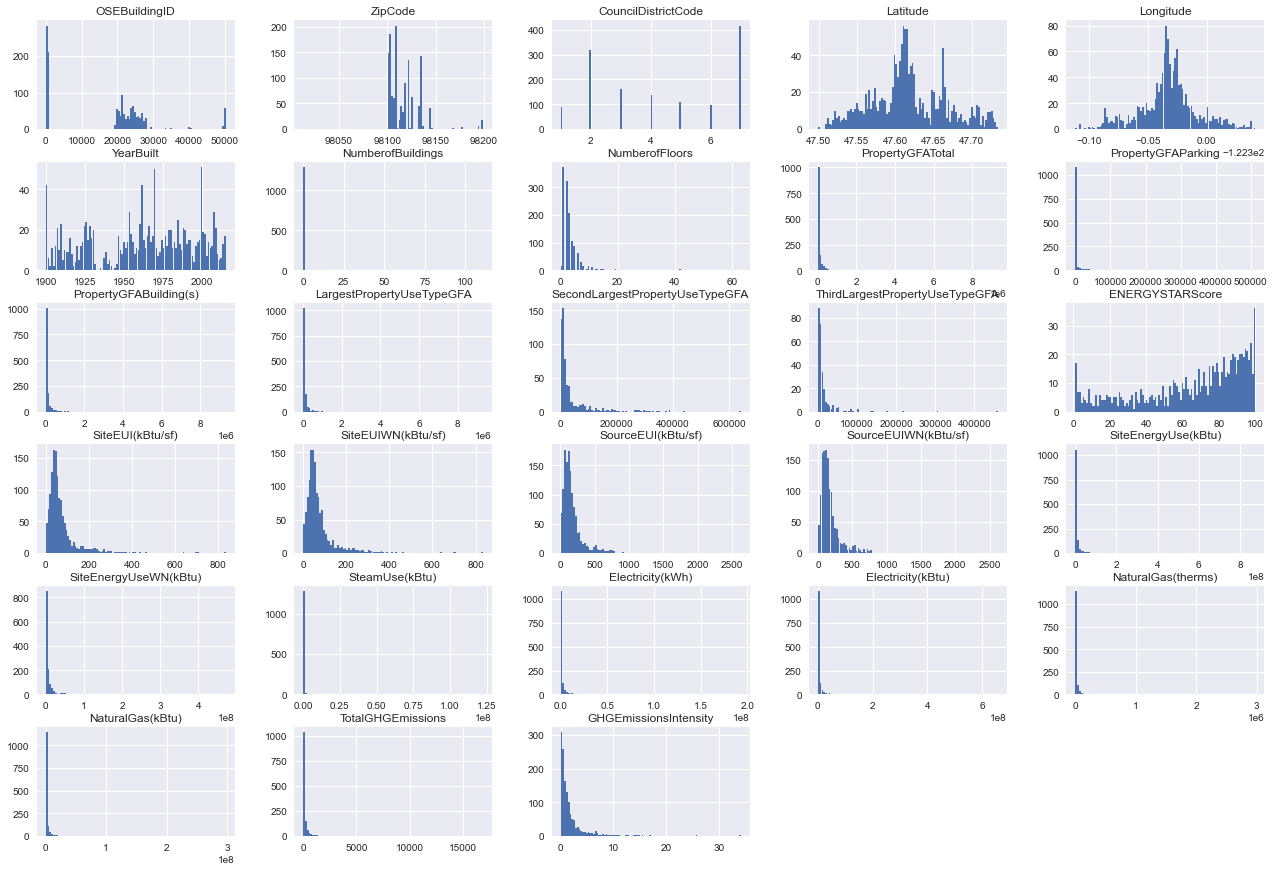

In [62]:
plt.style.use('seaborn')
df_train.hist(bins=100, figsize=(22,15))
plt.show()

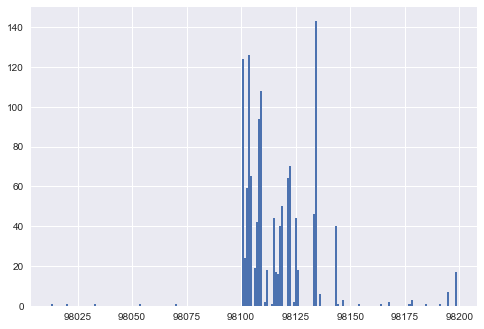

In [63]:
df_train['ZipCode'].hist(bins=200);

In [64]:
df_train['ZipCode'].value_counts().sort_index()

98013.0      1
98020.0      1
98033.0      1
98053.0      1
98070.0      1
98101.0    124
98102.0     24
98103.0     59
98104.0    126
98105.0     65
98106.0     19
98107.0     42
98108.0     94
98109.0    108
98111.0      2
98112.0     18
98114.0      1
98115.0     44
98116.0     17
98117.0     16
98118.0     40
98119.0     50
98121.0     64
98122.0     70
98124.0      2
98125.0     44
98126.0     18
98133.0     46
98134.0    143
98136.0      6
98144.0     40
98145.0      1
98146.0      3
98154.0      1
98164.0      1
98168.0      2
98177.0      1
98178.0      3
98185.0      1
98191.0      1
98195.0      7
98199.0     17
Name: ZipCode, dtype: int64

## Somme cumulée des variables à prédire

##### SiteEnergyUse(kBtu)

In [65]:
df_somme_cumulee_SiteEnergyUse = df_train['SiteEnergyUse(kBtu)'].copy().dropna()
df_somme_cumulee_SiteEnergyUse = df_somme_cumulee_SiteEnergyUse.sort_values(ascending=True, inplace=False).cumsum()
df_somme_cumulee_SiteEnergyUse.reset_index(inplace=True, drop=True)
df_somme_cumulee_SiteEnergyUse

0       1.680890e+04
1       4.091440e+04
2       8.520790e+04
3       1.575783e+05
4       2.372901e+05
            ...     
1314    9.466565e+09
1315    9.741247e+09
1316    1.003434e+10
1317    1.048272e+10
1318    1.135665e+10
Name: SiteEnergyUse(kBtu), Length: 1319, dtype: float64

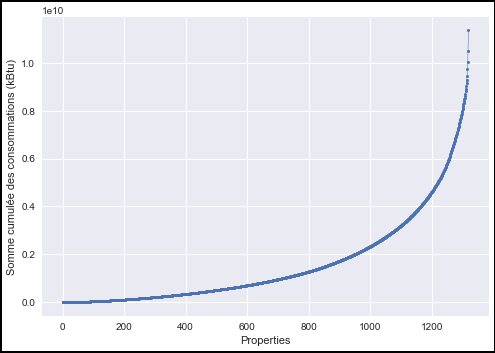

In [66]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
df_somme_cumulee_SiteEnergyUse.plot(marker='o', linewidth=0.5, markersize=3)
plt.xlabel('Properties')
plt.ylabel('Somme cumulée des consommations (kBtu)')
plt.show()

##### GHG

In [67]:
df_somme_cumulee_GHG = df_train['TotalGHGEmissions'].copy().dropna()
df_somme_cumulee_GHG = df_somme_cumulee_GHG.sort_values(ascending=True, inplace=False).cumsum()
df_somme_cumulee_GHG.reset_index(inplace=True, drop=True)
df_somme_cumulee_GHG

0           -0.80
1           -0.68
2           -0.51
3           -0.20
4            0.30
          ...    
1324    199865.45
1325    206196.36
1326    216930.93
1327    228071.49
1328    244942.47
Name: TotalGHGEmissions, Length: 1329, dtype: float64

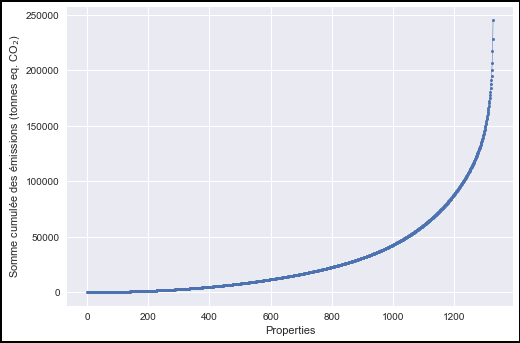

In [68]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
df_somme_cumulee_GHG.plot(marker='o', linewidth=0.5, markersize=3)
plt.xlabel('Properties')
plt.ylabel('Somme cumulée des émissions (tonnes eq. CO'+'$_2$'+')')
plt.show()

## Matrice de corrélation (heatmap)

In [69]:
df_corr = df_train.drop(columns=['OSEBuildingID', 'ZipCode', 'CouncilDistrictCode']).corr()
print("Matrice de corrélation :")
display(df_corr)

Matrice de corrélation :


,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
Latitude,1.000000,-0.118031,0.044295,0.022523,-0.001393,0.004900,0.031105,0.000645,0.006018,0.003021,-0.131980,0.047536,0.069794,0.071072,0.062656,0.063755,0.003010,-0.021471,-0.003894,0.005240,0.005240,-0.010200,-0.010200,-0.006824,0.042090
Longitude,-0.118031,1.000000,0.027165,0.019283,-0.030885,0.020306,-0.032769,0.025862,0.029756,0.022721,0.041023,0.009149,-0.030106,-0.028890,-0.027922,-0.026651,0.023932,0.010233,0.021455,0.018258,0.018258,0.018381,0.018381,0.027996,-0.001848
YearBuilt,0.044295,0.027165,1.000000,-0.036938,0.092585,0.091573,0.279040,0.055409,0.054506,0.303631,0.175265,-0.032813,0.127699,0.124021,0.158280,0.157567,0.053964,0.136910,-0.024640,0.062868,0.062868,0.061222,0.061222,0.044324,-0.003295
NumberofBuildings,0.022523,0.019283,-0.036938,1.000000,-0.030245,0.763322,-0.012081,0.797221,0.822804,0.151560,-0.009889,-0.018891,0.026714,0.051108,0.024499,0.039654,0.739452,0.201258,0.478796,0.775597,0.775597,0.048828,0.048828,0.446437,0.023282
NumberofFloors,-0.001393,-0.030885,0.092585,-0.030245,1.000000,0.398505,0.532722,0.338891,0.315406,0.518311,0.250714,0.148211,0.027602,0.020598,0.070164,0.068158,0.207065,0.326622,0.090704,0.271915,0.271915,0.015294,0.015294,0.115058,-0.049360
PropertyGFATotal,0.004900,0.020306,0.091573,0.763322,0.398505,1.000000,0.356720,0.990982,0.977503,0.819913,0.522918,0.159998,0.026690,0.026302,0.045317,0.057499,0.815022,0.546140,0.479470,0.867895,0.867895,0.131356,0.131356,0.524351,-0.013761
PropertyGFAParking,0.031105,-0.032769,0.279040,-0.012081,0.532722,0.356720,1.000000,0.228323,0.252756,0.506822,0.176119,0.109821,0.045709,0.040284,0.085444,0.083436,0.132071,0.204910,0.001760,0.179215,0.179215,0.024832,0.024832,0.056247,-0.091159
PropertyGFABuilding(s),0.000645,0.025862,0.055409,0.797221,0.338891,0.990982,0.228323,1.000000,0.982428,0.793334,0.552686,0.155535,0.021260,0.019433,0.034974,0.043672,0.830391,0.565784,0.499422,0.878763,0.878763,0.133330,0.133330,0.538369,-0.001267
LargestPropertyUseTypeGFA,0.006018,0.029756,0.054506,0.822804,0.315406,0.977503,0.252756,0.982428,1.000000,0.799341,0.479872,0.150253,0.020526,0.019975,0.030090,0.037148,0.852933,0.621711,0.548598,0.889522,0.889522,0.149051,0.149051,0.577099,0.027246
SecondLargestPropertyUseTypeGFA,0.003021,0.022721,0.303631,0.151560,0.518311,0.819913,0.506822,0.793334,0.799341,1.000000,0.673235,0.133543,0.088669,0.080914,0.110066,0.104978,0.676523,0.675343,0.214068,0.672452,0.672452,0.439594,0.439594,0.544140,0.148788


##### Représentation sous forme de heatmap

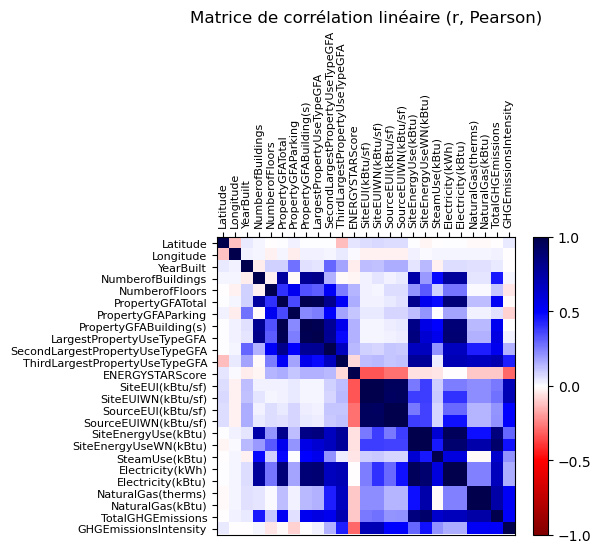

In [70]:
plt.style.use('default')
plt.matshow(df_corr, cmap='seismic_r', vmin=-1, vmax=1)
ticks = range(len(df_corr.columns))
plt.xticks(ticks,
           fontsize=8,
           labels=df_corr.columns,
           rotation=90)
plt.yticks(ticks, fontsize=8, labels=df_corr.columns)
plt.tick_params(bottom=False)
plt.colorbar(shrink=0.8, ticks=[-1, -0.5, 0, 0.5, 1])
plt.title('Matrice de corrélation linéaire (r, Pearson)')
plt.show()

##### Affichage des corrélations les plus fortes

In [71]:
df_corr_2 = pd.DataFrame(columns=['corrélation', 'var1', 'var2'])    # dataframe à 3 colonnes : 'corrélation', 'var1', 'var2'
for i in range(df_corr.shape[0]):
    for j in range(i):
        df_corr_2 = df_corr_2.append({'corrélation': df_corr.iloc[i,j], 'var1': df_corr.columns[i], 'var2': df_corr.columns[j]}, ignore_index=True)
df_corr_2 = df_corr_2.sort_values('corrélation', ascending=False, inplace=False)
df_corr_2 = df_corr_2.reset_index(drop=True)

In [72]:
df_corr_2.head(50)

,corrélation,var1,var2
0,1.000000,NaturalGas(kBtu),NaturalGas(therms)
1,1.000000,Electricity(kBtu),Electricity(kWh)
2,0.999295,SiteEnergyUseWN(kBtu),SiteEnergyUse(kBtu)
3,0.999182,SourceEUIWN(kBtu/sf),SourceEUI(kBtu/sf)
4,0.998835,SiteEUIWN(kBtu/sf),SiteEUI(kBtu/sf)
5,0.990982,PropertyGFABuilding(s),PropertyGFATotal
6,0.982428,LargestPropertyUseTypeGFA,PropertyGFABuilding(s)
7,0.977503,LargestPropertyUseTypeGFA,PropertyGFATotal
8,0.959245,Electricity(kWh),SiteEnergyUse(kBtu)
9,0.959245,Electricity(kBtu),SiteEnergyUse(kBtu)


In [73]:
df_corr_2.tail(10)

,corrélation,var1,var2
290,-0.104167,TotalGHGEmissions,ENERGYSTARScore
291,-0.104444,NaturalGas(therms),ENERGYSTARScore
292,-0.104444,NaturalGas(kBtu),ENERGYSTARScore
293,-0.118031,Longitude,Latitude
294,-0.131980,ThirdLargestPropertyUseTypeGFA,Latitude
295,-0.276439,SourceEUI(kBtu/sf),ENERGYSTARScore
296,-0.277272,SourceEUIWN(kBtu/sf),ENERGYSTARScore
297,-0.295458,GHGEmissionsIntensity,ENERGYSTARScore
298,-0.330239,SiteEUI(kBtu/sf),ENERGYSTARScore
299,-0.334471,SiteEUIWN(kBtu/sf),ENERGYSTARScore


###### Etape préliminaire

Avant de réaliser la PCA, on met à jour la liste des variables quantitatives en supprimant des variables fortement corrélées (r>0.99) :  

In [74]:
set_var_quanti_conservees = set(df_corr.columns) - {'NaturalGas(therms)', 'Electricity(kWh)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'PropertyGFATotal'}

La liste des variables qualitatives est la suivante :

In [75]:
set_var_quali = set(df_train.columns) - set(df_corr.columns)
set_var_quali

{'BuildingType',
 'CouncilDistrictCode',
 'LargestPropertyUseType',
 'Neighborhood',
 'OSEBuildingID',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'ZipCode'}

## PCA

###### Etape préliminaire

Avant de réaliser la PCA, on met à jour la liste des variables quantitatives en supprimant des variables fortement corrélées (r>0.99) :  

In [76]:
set_var_quanti_conservees = set(df_corr.columns) - {'NaturalGas(therms)', 'Electricity(kWh)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'PropertyGFATotal'}

La liste des variables qualitatives est la suivante :

In [77]:
set_var_quali = set(df_train.columns) - set(df_corr.columns)
set_var_quali

{'BuildingType',
 'CouncilDistrictCode',
 'LargestPropertyUseType',
 'Neighborhood',
 'OSEBuildingID',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'ZipCode'}

On analyse ici les corrélations entre les variables suivantes :  

In [78]:
print("Nb de variables :", len(set_var_quanti_conservees))
set_var_quanti_conservees

Nb de variables : 19


{'ENERGYSTARScore',
 'Electricity(kBtu)',
 'GHGEmissionsIntensity',
 'LargestPropertyUseTypeGFA',
 'Latitude',
 'Longitude',
 'NaturalGas(kBtu)',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SourceEUI(kBtu/sf)',
 'SteamUse(kBtu)',
 'ThirdLargestPropertyUseTypeGFA',
 'TotalGHGEmissions',
 'YearBuilt'}

##### Eboulis des valeurs propres

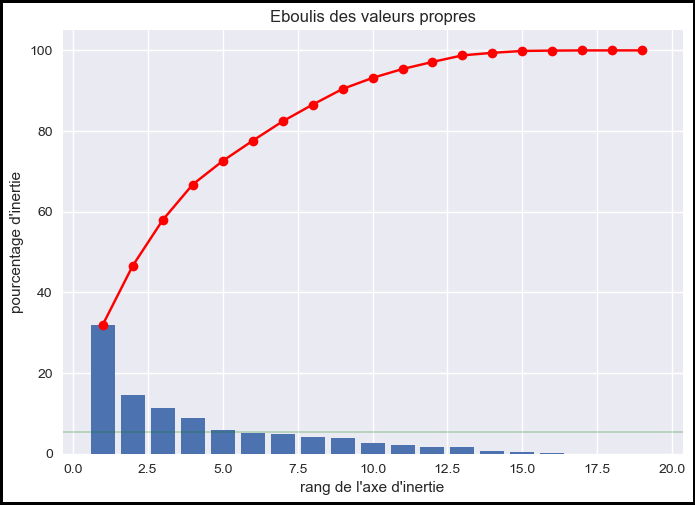

In [122]:
# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_train[set_var_quanti_conservees]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean(
))  # remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=len(set_var_quanti_conservees))
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

Interprétation de l'éboulis : 
- les variables sont modérément corrélées entre elles.
- en se basant sur le critère de Kaiser, matérialisé par le trait horizontal, on ne représentera les cercles des corrélations que pour les 6 premières composantes (F1 à F6).

##### Cercles des corrélations

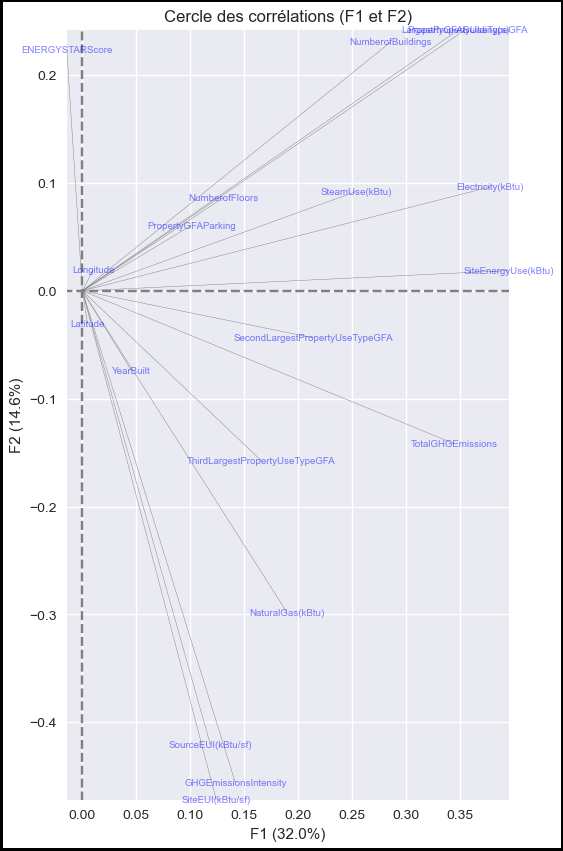

In [123]:
# Cercle des corrélations : premier plan factoriel
pcs = pca.components_
display_circles(pca, [(0,1)], labels = np.array(features), lims='auto')

Interprétation du premier plan factoriel (F1 et F2) :  
- les variables les plus corrélées à F1 sont les variables corrélées à la quantité d'énergie consommée par propriété.
- les variables les plus corrélées à F2 sont les variables (anti)corrélées à la quantité d'énergie consommée par unité de surface.

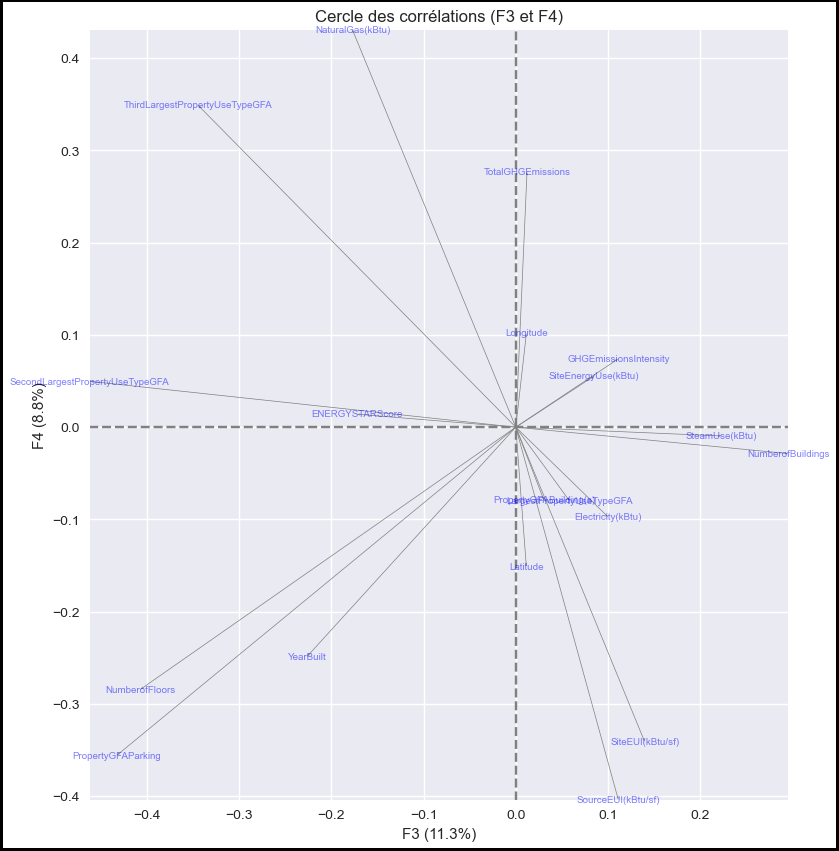

In [124]:
# Cercle des corrélations : second plan factoriel
display_circles(pca, [(2,3)], labels = np.array(features), lims='auto')

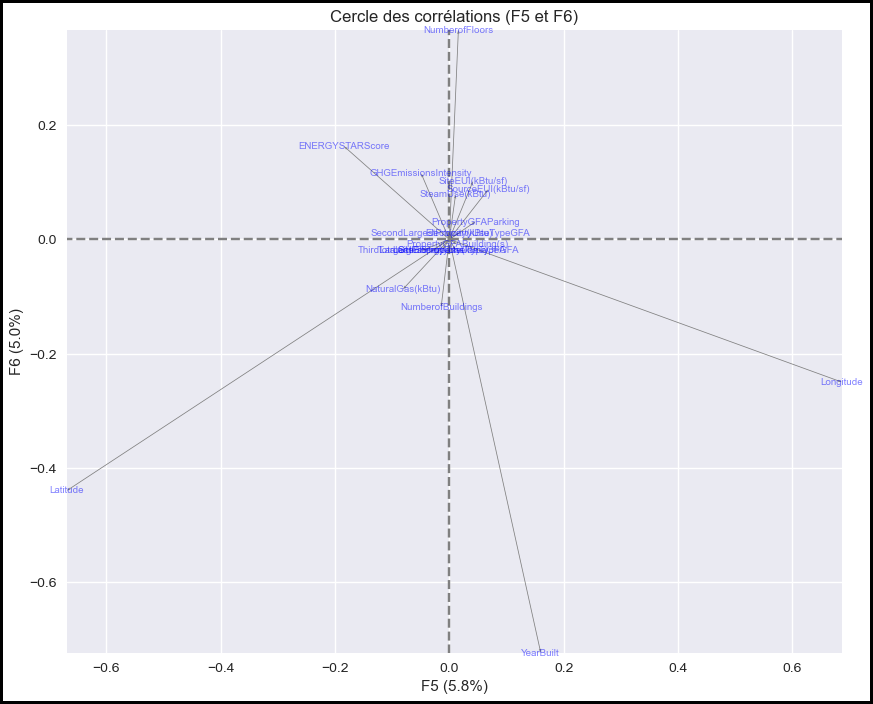

In [125]:
# Cercle des corrélations : 3è plan factoriel
display_circles(pca, [(4,5)], labels = np.array(features), lims='auto')

Interprétation du second plan factoriel (F3 et F4) et du troisième plan (F5 et F6) :  
- je ne vois pas comment on peut "interpréter" la signification de F3, F4, F5, F6.

## Scatter plots

### Variables avec r>0.99

In [ ]:
scatter_plot(ser_x=df_train['NaturalGas(kBtu)'], ser_y=df_train['NaturalGas(therms)'], max_x=4e7, max_y=4e5)
scatter_plot(ser_x=df_train['Electricity(kBtu)'], ser_y=df_train['Electricity(kWh)'], max_x=7e7, max_y=2.5e7)
scatter_plot(ser_x=df_train['SiteEnergyUse(kBtu)'], ser_y=df_train['SiteEnergyUseWN(kBtu)'], max_x=1e8, max_y=1e8)
scatter_plot(ser_x=df_train['SourceEUI(kBtu/sf)'], ser_y=df_train['SourceEUIWN(kBtu/sf)'])
scatter_plot(ser_x=df_train['SiteEUI(kBtu/sf)'], ser_y=df_train['SiteEUIWN(kBtu/sf)'])
scatter_plot(ser_x=df_train['PropertyGFABuilding(s)'], ser_y=df_train['PropertyGFATotal'], max_x=2e6, max_y=2e6)

### ENERGYSTARScore vs EnergyUse

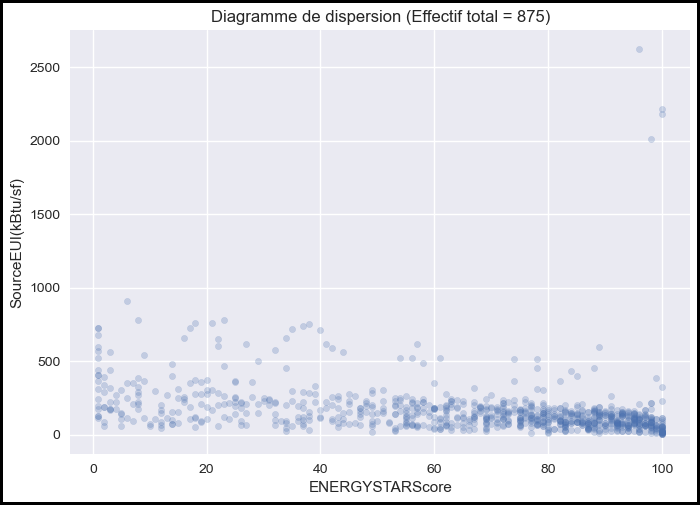

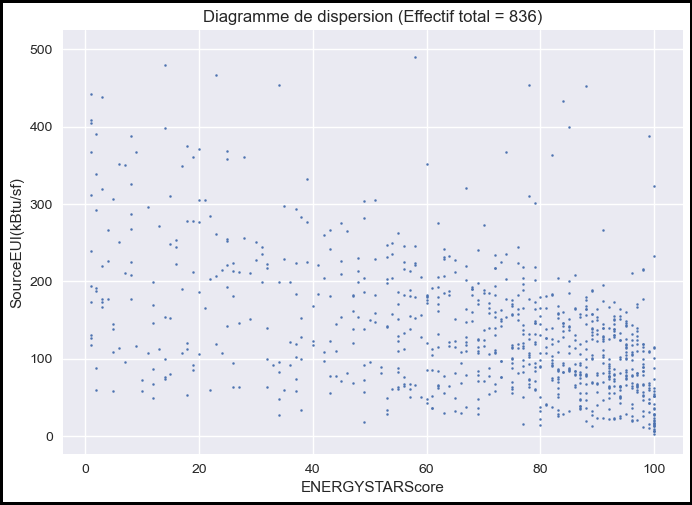

In [126]:
scatter_plot(ser_x=df_train['ENERGYSTARScore'], ser_y=df_train['SourceEUI(kBtu/sf)'], regression_lineaire=False, taille=20, alpha=0.25)
scatter_plot(ser_x=df_train['ENERGYSTARScore'], ser_y=df_train['SourceEUI(kBtu/sf)'], regression_lineaire=False, max_y=500)

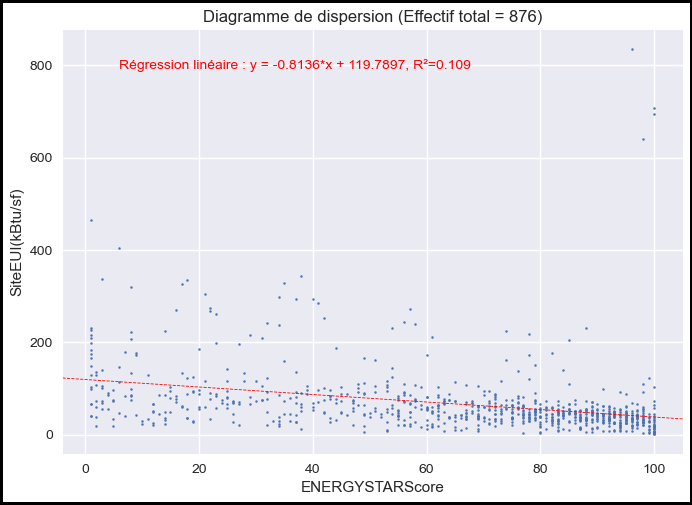

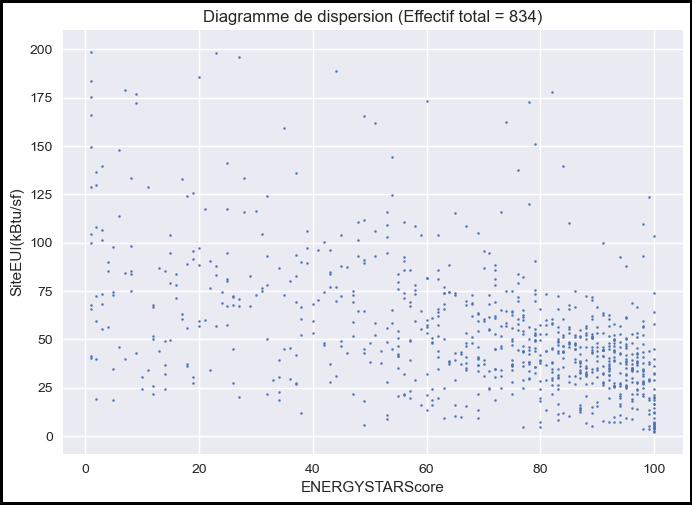

In [127]:
scatter_plot(ser_x=df_train['ENERGYSTARScore'], ser_y=df_train['SiteEUI(kBtu/sf)'], regression_lineaire=True)
scatter_plot(ser_x=df_train['ENERGYSTARScore'], ser_y=df_train['SiteEUI(kBtu/sf)'], regression_lineaire=False, max_y=200)

On observe bien une corrélation négative entre la variable ENERGYSTARScore et les variables SiteEUI / SourceEUI, mais cette tendance est faible.  
Certaines propriétés du premier centile (ENERGYSTARScore = 1) ont des consommations primaires (SourceEUI) inférieures à celles du dernier centile.  

Exemple extrême du dataset de 2016 : un lieu de culte du dataset (ID=22078, ENERGYSTARScore = 1) a 19 fois moins d'EUI qu'un datacenter (ID=440, ENERGYSTARScore = 100).  
Explication : le DataCenter est efficient énergétiquement par rapport à d'autres datacenters, le lieu de culte est inefficient par rapport à d'autres lieux de culte.  

In [128]:
df_train[df_train['ENERGYSTARScore']==1].sort_values('SourceEUIWN(kBtu/sf)', ascending=True)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ElectricityGHGEmissions,SteamUseGHGEmissions,NaturalGasGHGEmissions
1496,22078,NonResidential,Worship Facility,98122.0,3,CENTRAL,47.61010,-122.30838,1901,1.0,2,26560,0,26560,Worship Facility,26560.0,NaN,NaN,NaN,NaN,1.0,65.900002,69.000000,117.199997,121.099998,1.751484e+06,1.831347e+06,0.000,1.787758e+05,609983.0,11415.009770,1141501.0,64.88,2.44,4.252473,0.000000,60.625118
2247,24958,NonResidential,Warehouse,98134.0,2,GREATER DUWAMISH,47.57339,-122.33735,1964,1.0,1,33462,0,33462,Non-Refrigerated Warehouse,33462.0,NaN,NaN,NaN,NaN,1.0,41.400002,41.400002,130.100006,130.100006,1.386445e+06,1.386445e+06,0.000,4.063438e+05,1386445.0,0.000000,0.0,9.67,0.29,9.665549,0.000000,0.000000
657,19477,NonResidential,Warehouse,98108.0,2,GREATER DUWAMISH,47.54137,-122.33051,1976,1.0,1,44100,0,44100,Non-Refrigerated Warehouse,40000.0,NaN,NaN,NaN,NaN,1.0,40.500000,42.299999,127.099998,132.800003,1.618916e+06,1.692054e+06,0.000,4.744772e+05,1618916.0,0.000000,0.0,11.29,0.26,11.286212,0.000000,0.000000
1567,22502,NonResidential,Warehouse,98199.0,7,MAGNOLIA / QUEEN ANNE,47.66238,-122.38831,1974,1.0,1,25600,0,25600,Non-Refrigerated Warehouse,20600.0,Office,5000.0,NaN,NaN,1.0,67.599998,75.900002,173.000000,188.699997,1.730601e+06,1.943595e+06,0.000,3.662393e+05,1249609.0,4809.920410,480992.0,34.26,1.34,8.711598,0.000000,25.545485
3060,28025,Nonresidential COS,Warehouse,98134.0,2,GREATER DUWAMISH,47.59393,-122.32211,1967,1.0,2,22058,0,22058,Non-Refrigerated Warehouse,12644.0,Office,7286.0,NaN,NaN,1.0,99.699997,112.199997,193.600006,209.899994,1.987335e+06,2.235498e+06,0.000,2.484544e+05,847726.0,11396.080080,1139608.0,66.43,3.01,5.909893,0.000000,60.524581
2467,25737,NonResidential,Senior Care Community,98101.0,7,EAST,47.61318,-122.32747,1969,1.0,6,95117,26082,69035,Senior Care Community,69035.0,Parking,26082.0,NaN,NaN,1.0,104.300003,107.699997,239.899994,246.800003,7.202142e+06,7.437745e+06,0.000,1.262310e+06,4307003.0,28951.378910,2895138.0,183.79,1.93,30.026110,0.000000,153.760779
60,85,NonResidential,Senior Care Community,98133.0,5,NORTHWEST,47.72426,-122.35599,1970,1.0,2,93397,0,93397,Senior Care Community,93397.0,NaN,NaN,NaN,NaN,1.0,175.600006,181.600006,311.500000,320.000000,1.640256e+07,1.695975e+07,0.000,1.664566e+06,5679498.0,107230.640600,10723064.0,609.10,6.52,39.594406,0.000000,569.501929
1156,21117,NonResidential,Small- and Mid-Sized Office,98101.0,3,EAST,47.61063,-122.32741,1946,1.0,3,22667,0,22667,Office,22667.0,NaN,NaN,NaN,NaN,1.0,166.199997,182.699997,367.399994,387.100006,3.767135e+06,4.141811e+06,1639341.375,5.780459e+05,1972293.0,1555.010132,155501.0,148.55,6.55,13.749762,126.538475,8.258658
2029,24180,NonResidential,Medical Office,98144.0,5,NORTH,47.70440,-122.32285,1986,1.0,2,28385,7056,21329,Medical Office,20575.0,NaN,NaN,NaN,NaN,1.0,129.000000,129.000000,405.100006,405.100006,2.654316e+06,2.654316e+06,0.000,7.779354e+05,2654315.0,0.000000,0.0,18.50,0.65,18.504459,0.000000,0.000000
3065,28033,NonResidential,Distribution Center,98108.0,2,GREATER DUWAMISH,47.56160,-122.32603,1971,1.0,1,28320,0,28320,Distribution Center,28320.0,Parking,NaN,NaN,NaN,1.0,149.600006,155.500000,408.299988,414.399994,4.236396e+06,4.403066e+06,0.000,9.975452e+05,3403624.0,8327.719727,832772.0,67.96,2.40,23.728236,0.000000,44.228521


In [129]:
df_train[df_train['ENERGYSTARScore']==100].sort_values('SourceEUIWN(kBtu/sf)', ascending=False)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ElectricityGHGEmissions,SteamUseGHGEmissions,NaturalGasGHGEmissions
309,440,NonResidential,Mixed Use Property,98109.0,7,LAKE UNION,47.61915,-122.34857,2001,1.0,6,213834,104922,108912,Parking,104922.0,Data Center,54385.0,Office,37721.0,100.0,707.299988,707.299988,2217.800049,2217.800049,7.507389e+07,7.507389e+07,0.0,2.195702e+07,74917352.0,1565.250000,156525.0,530.59,2.48,522.283466,0.0,8.313043
3203,49780,NonResidential,Other,98121.0,7,DOWNTOWN,47.61449,-122.33956,1975,1.0,7,90679,35120,55559,Data Center,60000.0,Parking,30700.0,NaN,NaN,100.0,694.700012,694.700012,2181.300049,2181.300049,4.168064e+07,4.168064e+07,0.0,1.221590e+07,41680634.0,0.000000,0.0,290.57,3.20,290.574950,0.0,0.000000
357,503,NonResidential,Supermarket / Grocery Store,98134.0,2,GREATER DUWAMISH,47.56895,-122.33775,2008,1.0,1,63225,0,63225,Supermarket/Grocery Store,63225.0,NaN,NaN,NaN,NaN,100.0,103.199997,103.199997,323.899994,323.899994,6.522552e+06,6.522552e+06,0.0,1.911650e+06,6522551.0,0.000000,0.0,45.47,0.72,45.471713,0.0,0.000000
990,20435,NonResidential,Supermarket / Grocery Store,98126.0,1,SOUTHWEST,47.56197,-122.38109,1946,1.0,2,25762,0,25762,Supermarket/Grocery Store,25762.0,NaN,NaN,NaN,NaN,100.0,74.000000,74.000000,232.399994,232.399994,1.906385e+06,1.906385e+06,0.0,5.587294e+05,1906385.0,0.000000,0.0,13.29,0.52,13.290288,0.0,0.000000
2008,24132,NonResidential,Refrigerated Warehouse,98108.0,2,GREATER DUWAMISH,47.56680,-122.32149,1957,1.0,1,25520,0,25520,Refrigerated Warehouse,25200.0,NaN,NaN,NaN,NaN,100.0,63.900002,70.500000,114.800003,121.800003,1.610795e+06,1.777298e+06,0.0,1.686244e+05,575346.0,10354.483400,1035448.0,59.00,2.31,4.011006,0.0,54.992643
1977,24030,NonResidential,Retail Store,98118.0,2,GREATER DUWAMISH,47.53922,-122.28295,2002,1.0,2,54211,17471,36740,Retail Store,30000.0,Supermarket/Grocery Store,5000.0,Parking,4000.0,100.0,36.200001,36.200001,113.699997,113.699997,1.267463e+06,1.267463e+06,0.0,3.714721e+05,1267463.0,0.000000,0.0,8.84,0.16,8.836068,0.0,0.000000
2202,24769,NonResidential,Senior Care Community,98133.0,5,NORTH,47.70178,-122.32352,2009,1.0,6,244500,0,244500,Senior Care Community,244500.0,NaN,NaN,NaN,NaN,100.0,45.099998,46.299999,101.500000,103.199997,1.101964e+07,1.131474e+07,0.0,1.857741e+06,6338614.0,46810.261720,4681026.0,292.80,1.20,44.189403,0.0,248.609291
2927,27554,NonResidential,Warehouse,98108.0,2,GREATER DUWAMISH,47.56501,-122.32480,1974,1.0,1,35046,0,35046,Non-Refrigerated Warehouse,32546.0,NaN,NaN,NaN,NaN,100.0,32.700001,33.599998,88.300003,88.699997,1.063269e+06,1.092980e+06,0.0,2.465897e+05,841364.0,2219.050049,221905.0,17.65,0.50,5.865538,0.0,11.785375
1314,21505,NonResidential,Small- and Mid-Sized Office,98121.0,7,DOWNTOWN,47.61230,-122.34611,1909,1.0,5,66900,0,66900,Office,68048.0,NaN,NaN,NaN,NaN,100.0,24.000000,24.000000,73.599998,73.599998,1.634178e+06,1.634178e+06,0.0,4.615830e+05,1574921.0,592.570007,59257.0,14.13,0.21,10.979503,0.0,3.147139
1762,23331,NonResidential,Small- and Mid-Sized Office,98125.0,5,NORTH,47.72986,-122.29278,1985,1.0,3,33580,12990,20590,Office,20590.0,Parking,12990.0,NaN,NaN,100.0,19.900000,19.900000,62.500000,62.500000,4.095784e+05,4.095784e+05,0.0,1.200406e+05,409579.0,0.000000,0.0,2.86,0.09,2.855361,0.0,0.000000


### Somme des surfaces

#### 'PropertyGFATotal' = f('PropertyGFABuilding(s)' + 'PropertyGFAParking')

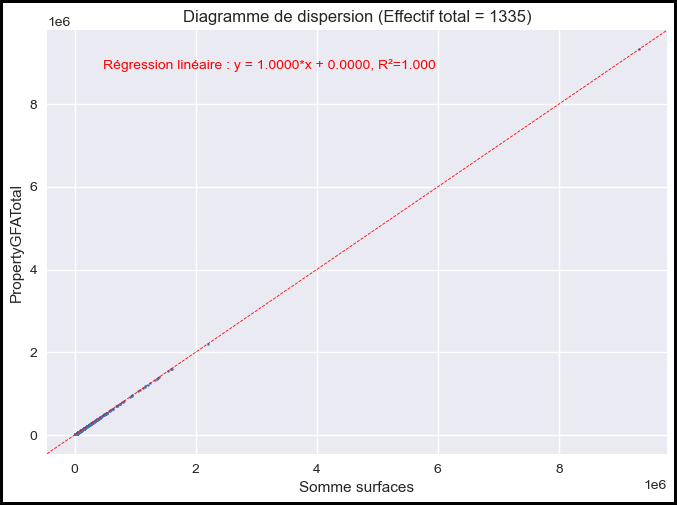

In [80]:
somme_surfaces = df_train['PropertyGFABuilding(s)'] + df_train['PropertyGFAParking']
somme_surfaces.name = 'Somme surfaces'
scatter_plot(ser_x=somme_surfaces, ser_y=df_train['PropertyGFATotal'])

La somme des surfaces (variables 'PropertyGFABuilding(s)' et 'PropertyGFAParking') correspond parfaitement à PropertyGFATotal.

#### somme_types_surfaces = 'LargestPropertyUseTypeGFA' + 'SecondLargestPropertyUseTypeGFA' + 'ThirdLargestPropertyUseTypeGFA'

In [81]:
somme_types_surfaces = df_train['LargestPropertyUseTypeGFA'].fillna(0) + df_train['SecondLargestPropertyUseTypeGFA'].fillna(0) + df_train['ThirdLargestPropertyUseTypeGFA'].fillna(0)
somme_types_surfaces.name = 'Somme surfaces : Largest+SecondLargest+ThirdLargest'

In [82]:
df_train[['PrimaryPropertyType', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']].sample(10, random_state=0)

,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
2247,Warehouse,33462,0,Non-Refrigerated Warehouse,33462.0,NaN,NaN,NaN,NaN
1648,Small- and Mid-Sized Office,48798,27307,Office,76105.0,NaN,NaN,NaN,NaN
198,Mixed Use Property,62900,0,Restaurant,32494.0,Other,29793.0,Retail Store,3384.300049
636,Warehouse,80360,0,Non-Refrigerated Warehouse,80360.0,NaN,NaN,NaN,NaN
612,Mixed Use Property,68100,54300,Office,41624.0,Parking,33399.0,Multifamily Housing,20740.000000
3131,Medical Office,30287,0,Medical Office,28050.0,NaN,NaN,NaN,NaN
985,Mixed Use Property,23315,0,Office,7758.0,Retail Store,6919.0,Restaurant,1976.000000
1975,Self-Storage Facility,23100,0,Self-Storage Facility,23250.0,NaN,NaN,NaN,NaN
357,Supermarket / Grocery Store,63225,0,Supermarket/Grocery Store,63225.0,NaN,NaN,NaN,NaN
1590,Warehouse,42500,0,Non-Refrigerated Warehouse,42500.0,Retail Store,5091.0,NaN,NaN


Exemples de data problématiques :  
- le bâtiment n°4 est un hotel. LargestPropertyUseType est l'hotel (surface supérieure au GFA Building). SecondLargestPropertyUseType est sa piscine.  
- le bâtiment n°444 : la superficie de parking est 0 (variable PropertyGFAParking) et 31348 (variable SecondLargestPropertyUseTypeGFA).

In [83]:
somme_types_surfaces.sample(10, random_state=0)

2247    33462.000000
1648    76105.000000
198     65671.300049
636     80360.000000
612     95763.000000
3131    28050.000000
985     16653.000000
1975    23250.000000
357     63225.000000
1590    47591.000000
Name: Somme surfaces : Largest+SecondLargest+ThirdLargest, dtype: float64

In [84]:
somme_types_surfaces.sort_values().head(10)

1147        0.0
2459        0.0
2414        0.0
353         0.0
2670        0.0
2019     8223.0
1568    10200.0
3363    11285.0
3361    11685.0
2985    12806.0
Name: Somme surfaces : Largest+SecondLargest+ThirdLargest, dtype: float64

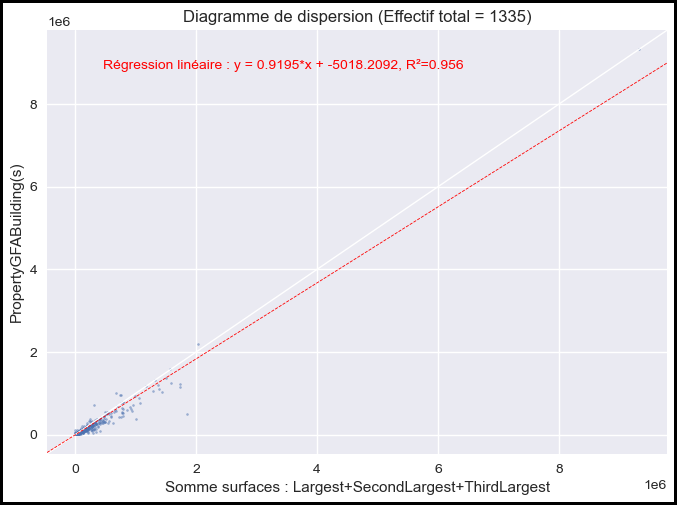

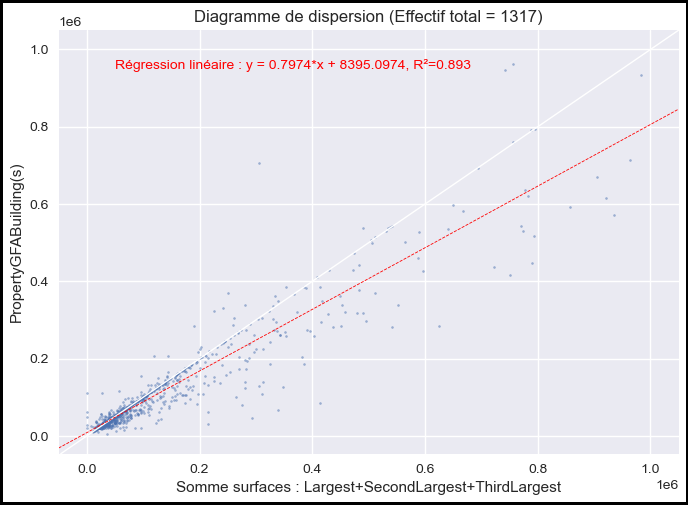

In [85]:
scatter_plot(ser_x=somme_types_surfaces, ser_y=df_train['PropertyGFABuilding(s)'], alpha=0.5, droite_identite=True)
scatter_plot(ser_x=somme_types_surfaces, ser_y=df_train['PropertyGFABuilding(s)'], alpha=0.5, droite_identite=True, max_x=1e6, max_y=1e6)

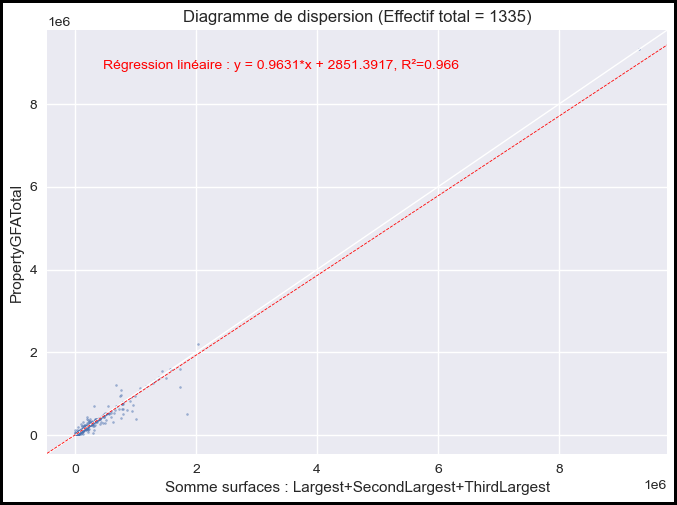

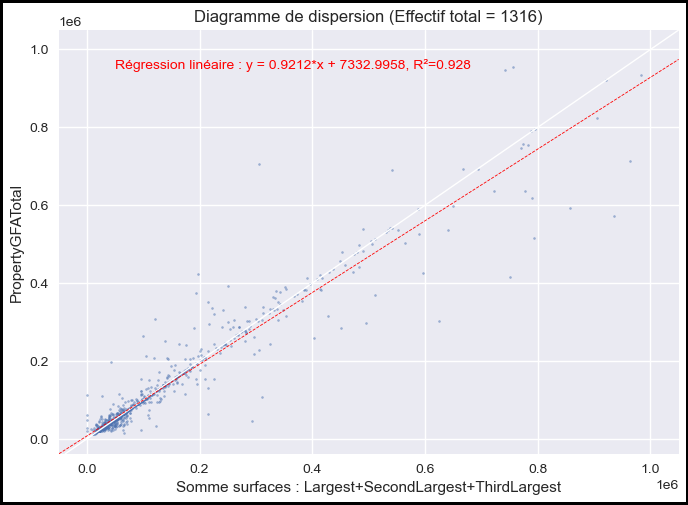

In [86]:
scatter_plot(ser_x=somme_types_surfaces, ser_y=df_train['PropertyGFATotal'], alpha=0.5, droite_identite=True)
scatter_plot(ser_x=somme_types_surfaces, ser_y=df_train['PropertyGFATotal'], alpha=0.5, droite_identite=True, max_x=1e6, max_y=1e6)

La variable somme_types_surfaces corrèle mieux avec 'PropertyGFATotal' (qui inclue les parkings) qu'avec 'PropertyGFABuilding(s)'.  
En analysant différentes lignes du tableau des surfaces des différents UseType, on voit que les données sont problématiques (les totaux recalculés par mes soins diffèrent des totaux fournis par les dataset).

### Somme des énergies consommées

##### 2015

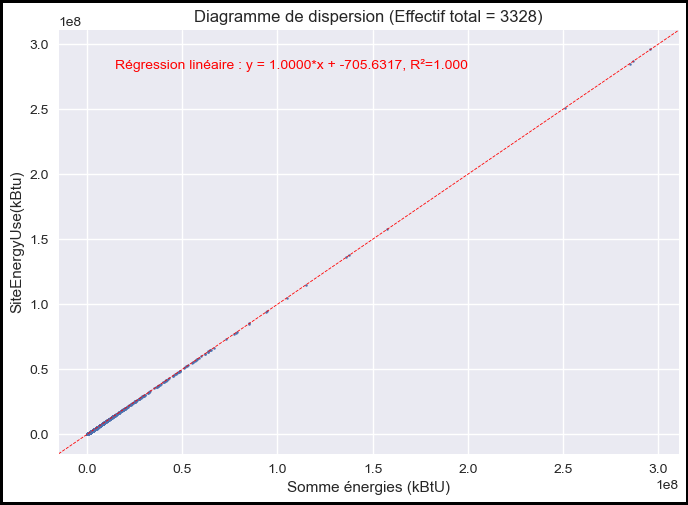

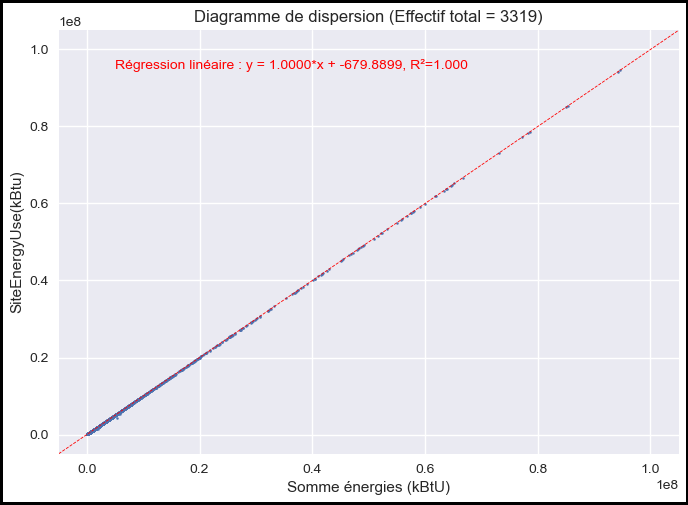

In [87]:
somme_energies_2015 = df2015['SteamUse(kBtu)'] + df2015['Electricity(kBtu)'] + df2015['NaturalGas(kBtu)'] + df2015['OtherFuelUse(kBtu)']
somme_energies_2015.name = 'Somme énergies (kBtU)'
scatter_plot(ser_x=somme_energies_2015, ser_y=df2015['SiteEnergyUse(kBtu)'])
scatter_plot(ser_x=somme_energies_2015, ser_y=df2015['SiteEnergyUse(kBtu)'], max_x=1e8, max_y=1e8)

Corrélation parfaite entre la somme des 4 variables de conso d'énergies (steam, electricity, natural gas, other fuel) et la variable SiteEnergyUse.

##### 2016

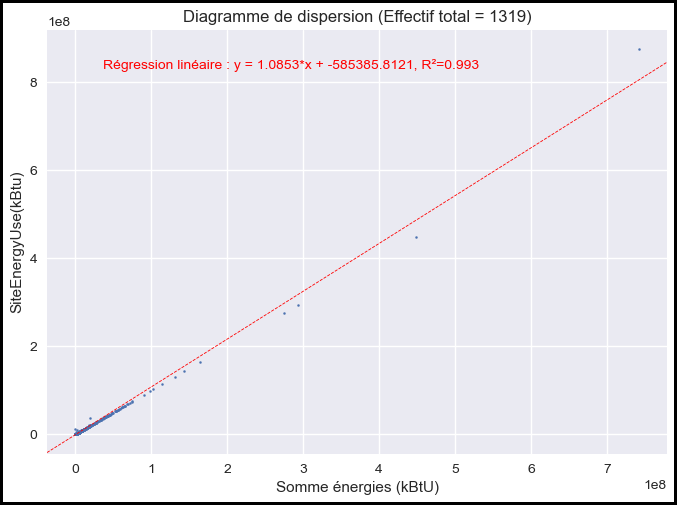

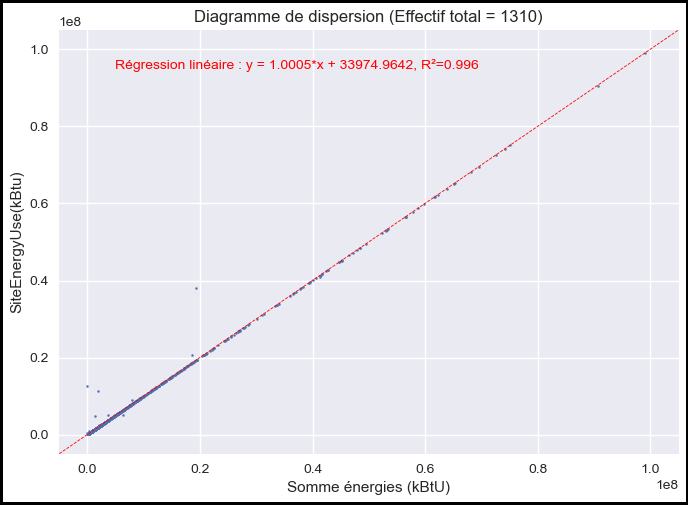

In [88]:
somme_energies_2016 = df_train['SteamUse(kBtu)'] + df_train['Electricity(kBtu)'] + df_train['NaturalGas(kBtu)']
somme_energies_2016.name = 'Somme énergies (kBtU)'
scatter_plot(ser_x=somme_energies_2016, ser_y=df_train['SiteEnergyUse(kBtu)'])
scatter_plot(ser_x=somme_energies_2016, ser_y=df_train['SiteEnergyUse(kBtu)'], max_x=1e8, max_y=1e8)

Pour certains bâtiments il y a un écart significatif entre la somme des 3 variables de conso d'énergies (steam, electricity, natural gas) et la variable SiteEnergyUse. Dû à l'absence de la variable 'OtherFuelUse(kBtu)' dans le dataset de 2016.

### 'SiteEUI(kBtu/sf)' vs 'SourceEUI(kBtu/sf)'

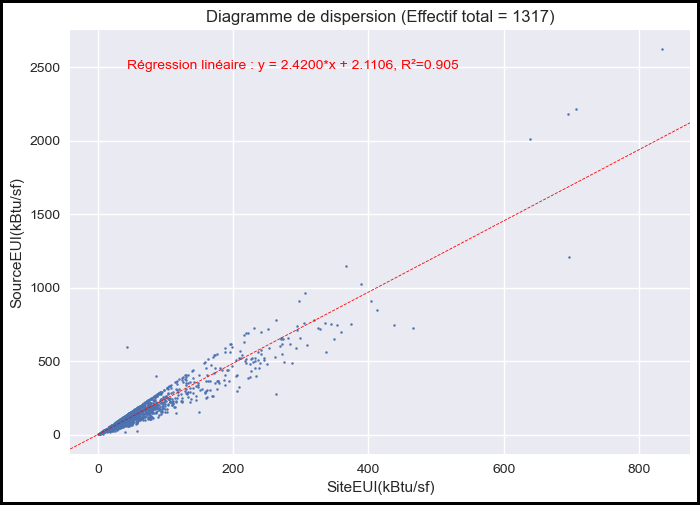

In [89]:
scatter_plot(ser_x=df_train['SiteEUI(kBtu/sf)'], ser_y=df_train['SourceEUI(kBtu/sf)'])

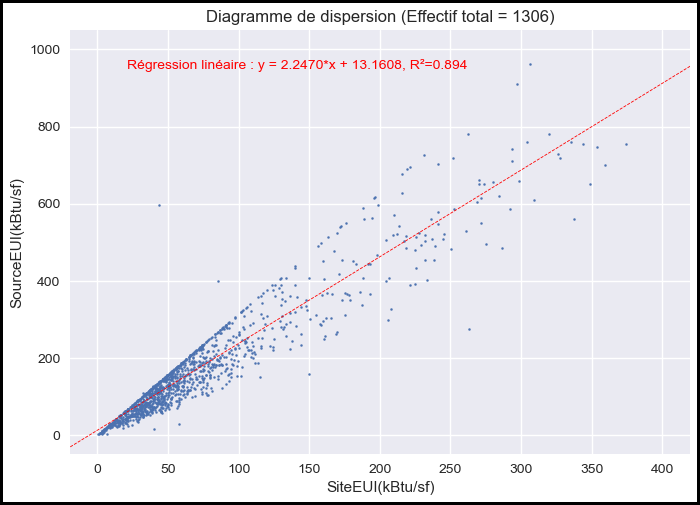

In [90]:
scatter_plot(ser_x=df_train['SiteEUI(kBtu/sf)'], ser_y=df_train['SourceEUI(kBtu/sf)'], max_x=400, max_y=1000)

### Consommations normalisé vs non normalisé

##### 2015 :

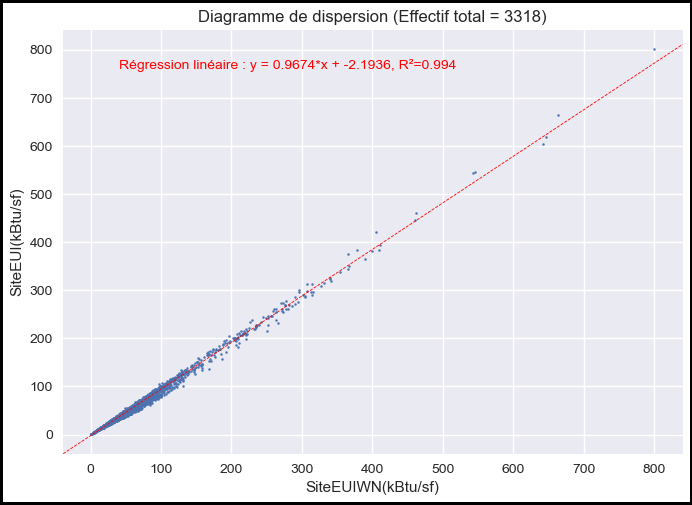

In [91]:
scatter_plot(ser_x=df2015['SiteEUIWN(kBtu/sf)'], ser_y=df2015['SiteEUI(kBtu/sf)'])

En 2015, la consommation d'énergie a été de 96.74% d'une année normalisée (WN).

##### 2016 :

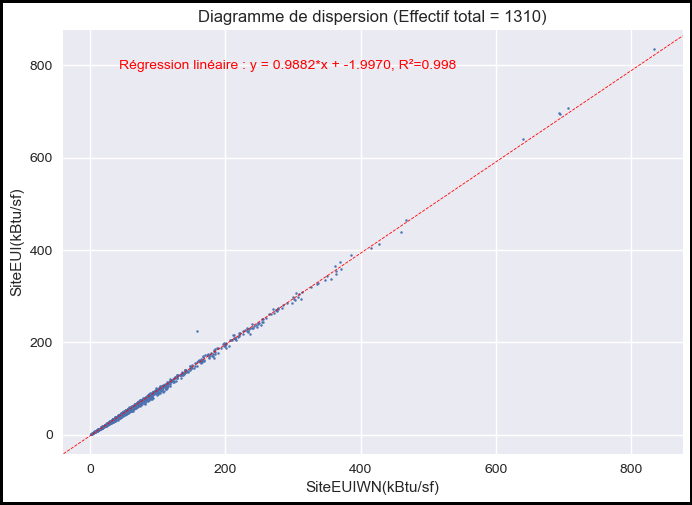

In [92]:
scatter_plot(ser_x=df_train['SiteEUIWN(kBtu/sf)'], ser_y=df_train['SiteEUI(kBtu/sf)'])

En 2016, la consommation d'énergie a été de 98.68% d'une année normalisée (WN).

### SiteEUIWN(kBtu/sf) 2015 vs 2016

In [93]:
df2015_conso = df2015[['OSEBuildingID', 'SiteEUIWN(kBtu/sf)']].copy()
df2015_conso.rename(columns = {'SiteEUIWN(kBtu/sf)' : 'SiteEUIWN(kBtu/sf)_2015'}, inplace = True)
df2016_conso = df_train[['OSEBuildingID', 'SiteEUIWN(kBtu/sf)']].copy()
df2016_conso.rename(columns = {'SiteEUIWN(kBtu/sf)' : 'SiteEUIWN(kBtu/sf)_2016'}, inplace = True)
# Fusion sur la colonne OSEBuildingID
df_conso = pd.merge(df2015_conso, df2016_conso, on=['OSEBuildingID'])
df_conso

,OSEBuildingID,SiteEUIWN(kBtu/sf)_2015,SiteEUIWN(kBtu/sf)_2016
0,1,80.3,84.300003
1,3,99.7,97.699997
2,5,462.5,113.300003
3,9,146.9,141.600006
4,10,79.6,74.500000
...,...,...,...
1294,49966,54.1,56.200001
1295,49985,40.7,39.400002
1296,49998,9.7,10.700000
1297,50002,35.6,35.900002


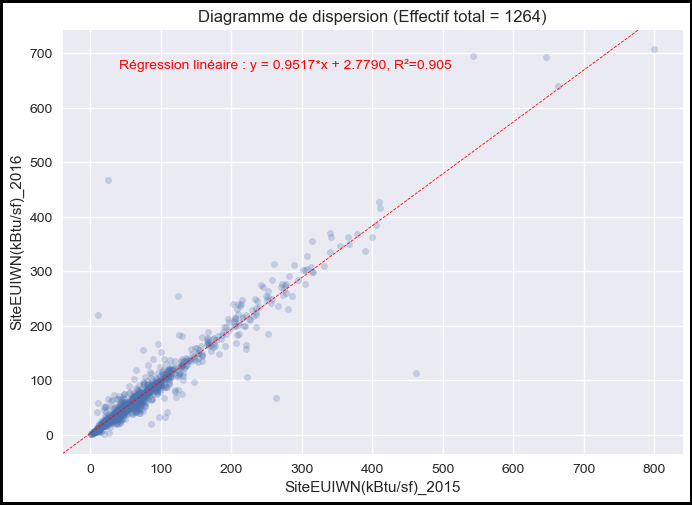

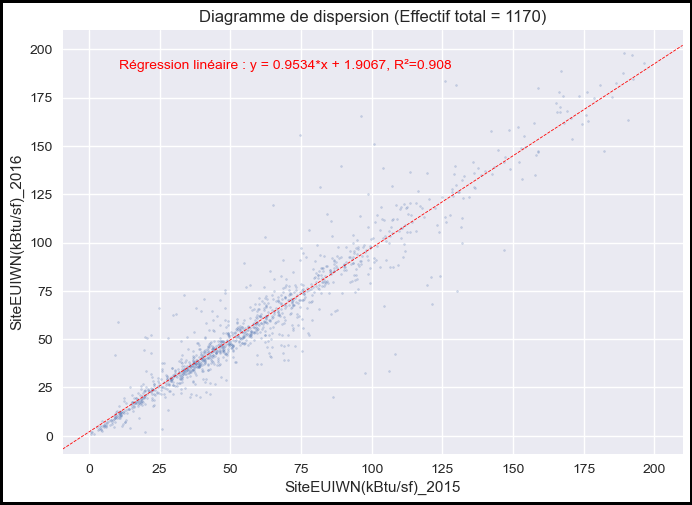

In [94]:
scatter_plot(ser_x=df_conso['SiteEUIWN(kBtu/sf)_2015'], ser_y=df_conso['SiteEUIWN(kBtu/sf)_2016'], taille=20, alpha=0.25)
scatter_plot(ser_x=df_conso['SiteEUIWN(kBtu/sf)_2015'], ser_y=df_conso['SiteEUIWN(kBtu/sf)_2016'], alpha=0.25, max_x=200, max_y=200)

Ce graphique montre deux choses :  
    - les consommations normalisées baissent (pente < 1) entre 2015 et 2016 (meilleures isolations des bâtiments ?).  
    - bien qu'il y ait globalement une corrélation linéaire entre les données pour 2015 et 2016, la dispersion reste importante, et ON EVITERA D'UTILISER UN JEU DE DONNEES QUI MELANGE DES VALEURS DE 2015 ET 2016 pour la mise au point du modèle prédictif. 

### GHGEmissionsIntensity = f('SiteEUIWN(kBtu/sf)')

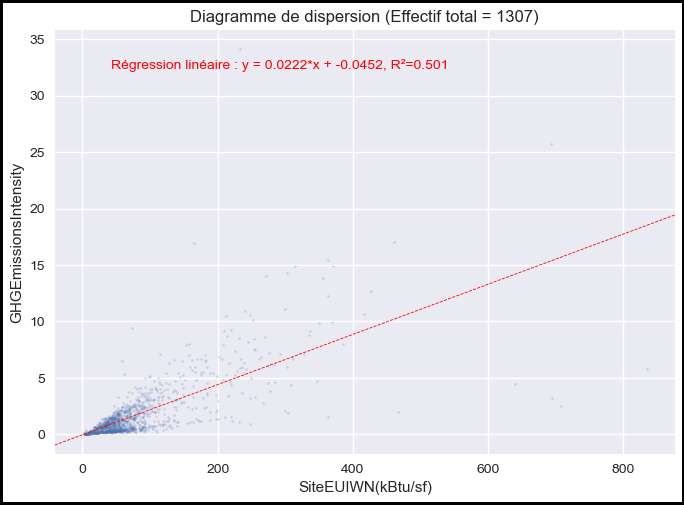

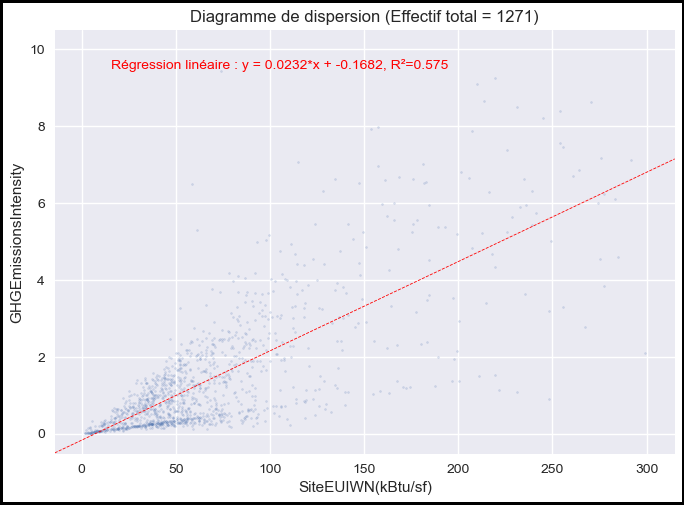

In [95]:
scatter_plot(ser_x=df_train['SiteEUIWN(kBtu/sf)'], ser_y=df_train['GHGEmissionsIntensity'], alpha=0.2, max_x=None, max_y=None)
scatter_plot(ser_x=df_train['SiteEUIWN(kBtu/sf)'], ser_y=df_train['GHGEmissionsIntensity'], alpha=0.2, max_x=300, max_y=10)

### 'SiteEnergyUse(kBtu)' = f('SiteEUI(kBtu/sf)'*Surface)

#### Surface = 'PropertyGFABuilding(s)'

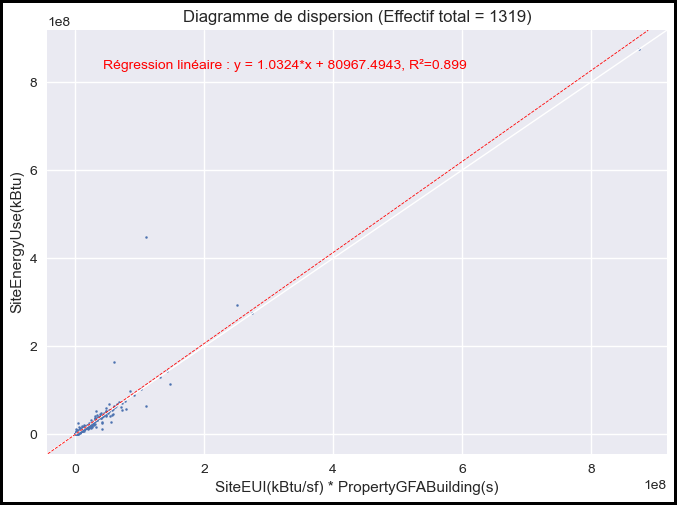

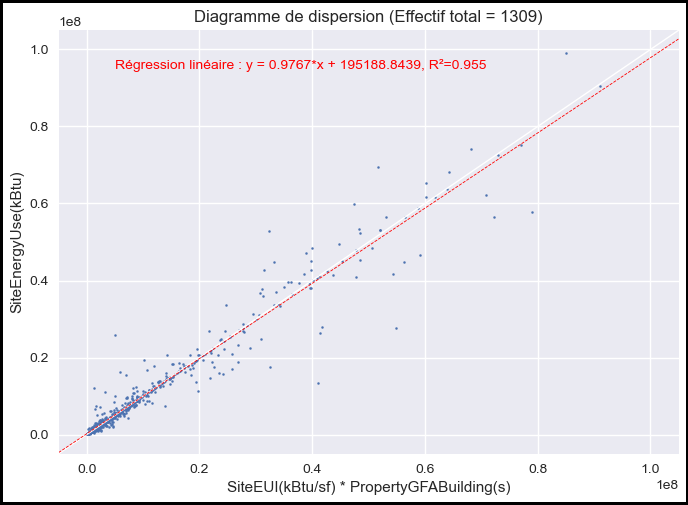

In [96]:
ser_x = df_train['SiteEUI(kBtu/sf)']*df_train['PropertyGFABuilding(s)']
ser_x.name = 'SiteEUI(kBtu/sf) * PropertyGFABuilding(s)'
scatter_plot(ser_x=ser_x, ser_y=df_train['SiteEnergyUse(kBtu)'], alpha=1, max_x=None, max_y=None, droite_identite=True)
scatter_plot(ser_x=ser_x, ser_y=df_train['SiteEnergyUse(kBtu)'], alpha=1, max_x=1e8, max_y=1e8, droite_identite=True)

#### Surface = 'PropertyGFATotal'

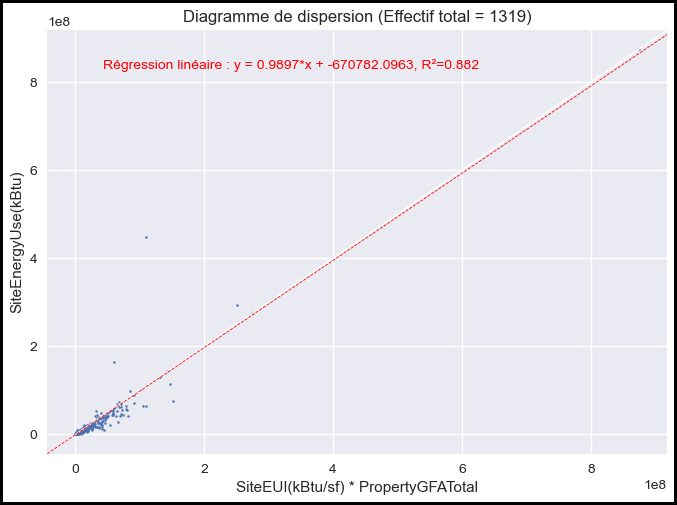

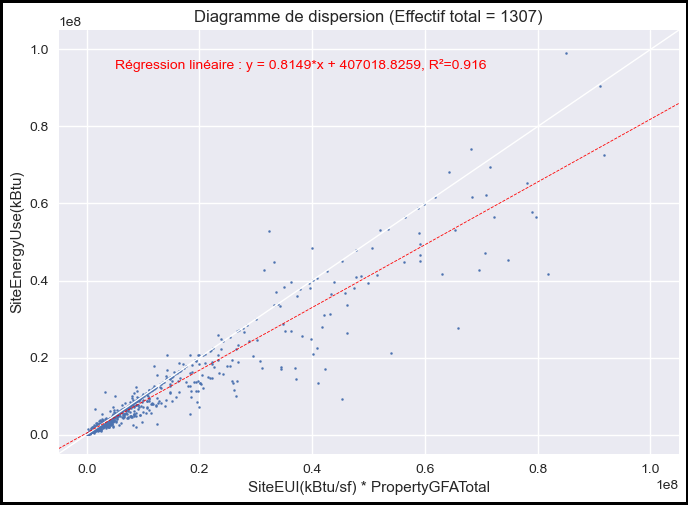

In [97]:
ser_x = df_train['SiteEUI(kBtu/sf)']*df_train['PropertyGFATotal']
ser_x.name = 'SiteEUI(kBtu/sf) * PropertyGFATotal'
scatter_plot(ser_x=ser_x, ser_y=df_train['SiteEnergyUse(kBtu)'], alpha=1, max_x=None, max_y=None, droite_identite=True)
scatter_plot(ser_x=ser_x, ser_y=df_train['SiteEnergyUse(kBtu)'], alpha=1, max_x=1e8, max_y=1e8, droite_identite=True)

#### Surface = somme_types_surfaces

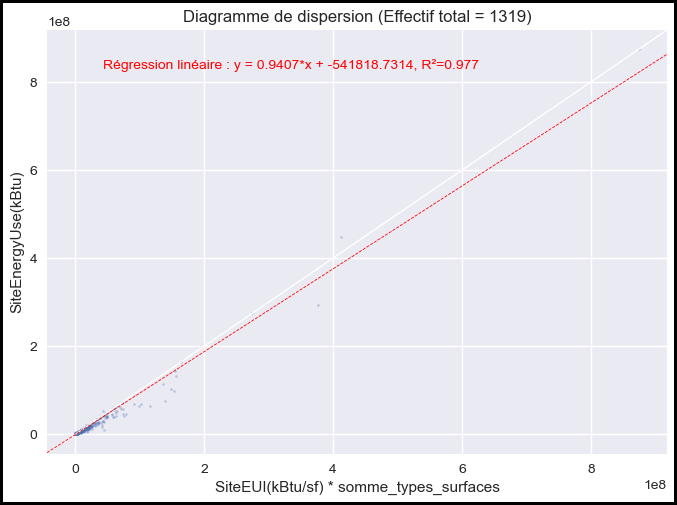

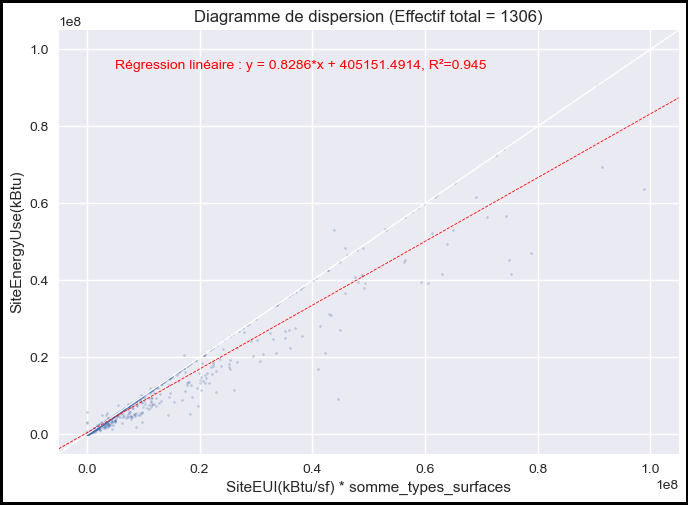

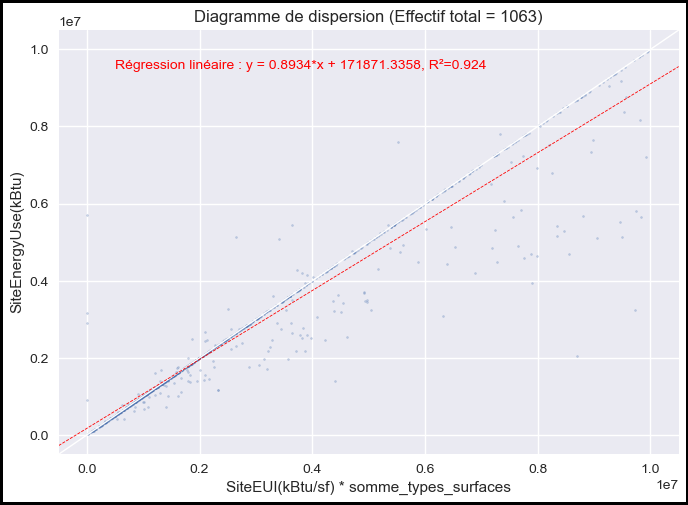

In [98]:
ser_x = df_train['SiteEUI(kBtu/sf)']*somme_types_surfaces
ser_x.name = 'SiteEUI(kBtu/sf) * somme_types_surfaces'
scatter_plot(ser_x=ser_x, ser_y=df_train['SiteEnergyUse(kBtu)'], alpha=0.3, max_x=None, max_y=None, droite_identite=True)
scatter_plot(ser_x=ser_x, ser_y=df_train['SiteEnergyUse(kBtu)'], alpha=0.3, max_x=1e8, max_y=1e8, droite_identite=True)
scatter_plot(ser_x=ser_x, ser_y=df_train['SiteEnergyUse(kBtu)'], alpha=0.3, max_x=1e7, max_y=1e7, droite_identite=True)

La meilleure corrélation entre la variable 'SiteEnergyUse(kBtu)' et la variable 'SiteEUI(kBtu/sf)'*Surface a été obtenue pour Surface = somme_types_surfaces (R²=0.98).

Il est plausible que la variable SiteEUI ait été calculée en divisant SiteEnergyUse par une variable de type Surface, hélas non renseignée dans le dataset. Les points bleus sur le scatter plot sont situés sous la droite y=x, ce qui veut dire que notre variable somme_types_surfaces minore la valeur réelle de cette surface.

### Somme des émissions de GHG

#### Création des variables ElectricityGHGEmissions, SteamUseGHGEmissions, NaturalGasGHGEmissions (exprimées en metric tons of CO2e equivalent)

In [99]:
df_train['ElectricityGHGEmissions'] = 52.44/2204.6/1000 * df_train['Electricity(kWh)'].copy()     # Electricity : 52.44 lbs CO2e/MWh    1MT=2204.6lbs

<ipython-input-99-a99be406164f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ElectricityGHGEmissions'] = 52.44/2204.6/1000 * df_train['Electricity(kWh)'].copy()     # Electricity : 52.44 lbs CO2e/MWh    1MT=2204.6lbs


In [100]:
df_train['SteamUseGHGEmissions'] = 170.17/2204.6/1000 * df_train['SteamUse(kBtu)'].copy()    # 'SteamUse(kBtu)' : 170.17 lbs CO2e/MMBtu

<ipython-input-100-18a5298415cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['SteamUseGHGEmissions'] = 170.17/2204.6/1000 * df_train['SteamUse(kBtu)'].copy()    # 'SteamUse(kBtu)' : 170.17 lbs CO2e/MMBtu


In [101]:
df_train['NaturalGasGHGEmissions'] = 53.11/1000/1000 * df_train['NaturalGas(kBtu)'].copy()    # NaturalGas : 53.11 kg CO2e/MBtu

<ipython-input-101-79033bea4ada>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['NaturalGasGHGEmissions'] = 53.11/1000/1000 * df_train['NaturalGas(kBtu)'].copy()    # NaturalGas : 53.11 kg CO2e/MBtu


In [102]:
df_train[['TotalGHGEmissions', 'ElectricityGHGEmissions', 'SteamUseGHGEmissions', 'NaturalGasGHGEmissions']].sample(10, random_state=0)

,TotalGHGEmissions,ElectricityGHGEmissions,SteamUseGHGEmissions,NaturalGasGHGEmissions
2247,9.67,9.665549,0.0,0.000000
1648,17.24,17.235893,0.0,0.000000
198,377.27,26.407430,0.0,350.865745
636,16.27,3.046663,0.0,13.224390
612,79.39,27.049930,0.0,52.337621
3131,32.72,12.656025,0.0,20.060178
985,35.04,5.570402,0.0,29.474510
1975,13.87,4.835348,0.0,9.034595
357,45.47,45.471713,0.0,0.000000
1590,1.68,1.683458,0.0,0.000000


#### somme_types_emissions = 'ElectricityGHGEmissions' + 'SteamUseGHGEmissions' + 'NaturalGasGHGEmissions'

In [103]:
somme_types_emissions = df_train['ElectricityGHGEmissions'].fillna(0) + df_train['SteamUseGHGEmissions'].fillna(0) + df_train['NaturalGasGHGEmissions'].fillna(0)

In [104]:
somme_types_emissions.name = 'Somme 3 émissions GHG (tonnes)'

In [105]:
somme_types_emissions.sample(10, random_state=0)

2247      9.665549
1648     17.235893
198     377.273174
636      16.271053
612      79.387552
3131     32.716203
985      35.044912
1975     13.869943
357      45.471713
1590      1.683458
Name: Somme 3 émissions GHG (tonnes), dtype: float64

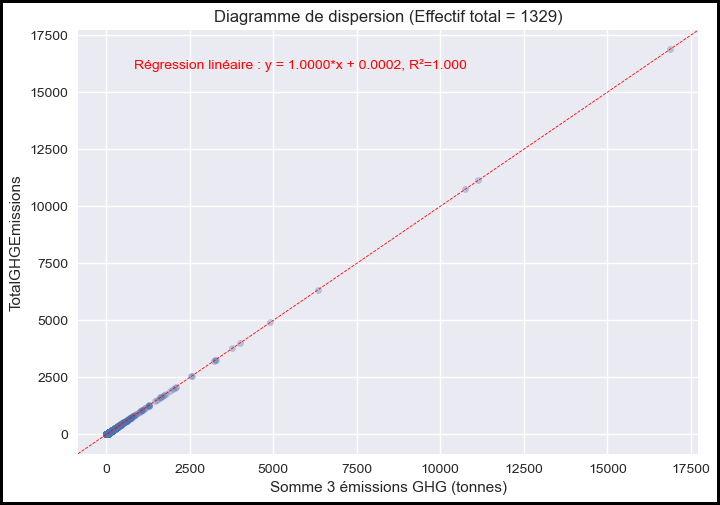

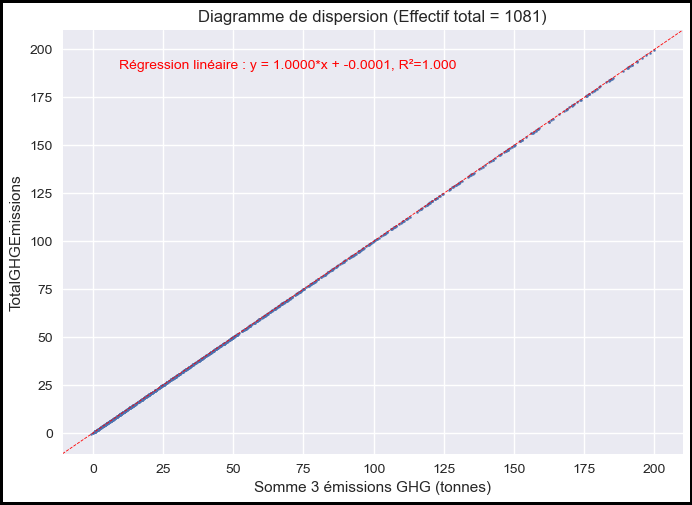

In [106]:
scatter_plot(ser_x=somme_types_emissions, ser_y=df_train['TotalGHGEmissions'], alpha=0.33, taille = 20, droite_identite=False)
scatter_plot(ser_x=somme_types_emissions, ser_y=df_train['TotalGHGEmissions'], alpha=1, droite_identite=False, max_x=200, max_y=200)

Corrélation parfaite entre la somme des 3 variables d'émissions d'énergies créées (steam, electricity, natural gas) et la variable TotalGHGEmissions.  
$\Rightarrow$  il suffira de déterminer chaque type d'émission (ou de consommation) pour en déduire TotalGHGEmissions.


### Latitude / longitude

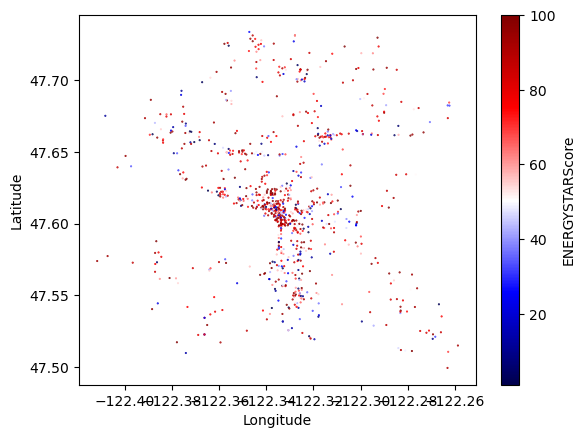

In [107]:
plt.style.use('default')
df_train.plot(kind="scatter", x="Longitude", y="Latitude", c='ENERGYSTARScore', label=None, cmap=plt.get_cmap("seismic"), alpha=1, marker='.', s=1);

## Notes sur l'analyse exploratoire

##### Variables WN (weather normalized)

Elles prennent trop souvent la valeur zéro.  
Après suppression des valeurs fausses zéro, la corrélation avec leur équivalent non WN est très élevée.  
Ces variables ne sont donc pas utilisées pour le modèle prédictif.

##### Variables retenues pour les modèles prédictifs

In [108]:
set_var_quanti_conservees  

{'ENERGYSTARScore',
 'Electricity(kBtu)',
 'GHGEmissionsIntensity',
 'LargestPropertyUseTypeGFA',
 'Latitude',
 'Longitude',
 'NaturalGas(kBtu)',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SourceEUI(kBtu/sf)',
 'SteamUse(kBtu)',
 'ThirdLargestPropertyUseTypeGFA',
 'TotalGHGEmissions',
 'YearBuilt'}

In [109]:
set_var_quali

{'BuildingType',
 'CouncilDistrictCode',
 'LargestPropertyUseType',
 'Neighborhood',
 'OSEBuildingID',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'ZipCode'}

# Application des nettoyages et feature engineering réalisés sur df_train à df_test

##### Nettoyages

In [110]:
df_test = df_test[liste_var_conservees].copy()

In [111]:
# Suppression des modalités 'Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)'
ser_bool = df_test['BuildingType'].isin(['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)'])
df_test = df_test[~ser_bool]

In [112]:
# suppression des valeurs zéros pour les variables dans liste_var_nettoyees_zero
suppression_zeros(df_test)

              Variable                 Nb de valeurs avant nettoyage    Nb de remplacements NaN   %remplacés
-------------------------------------------------------------------------------------------------------------
          PropertyGFATotal                          333                            0                0.00%   
     LargestPropertyUseTypeGFA                      332                            0                0.00%   
  SecondLargestPropertyUseTypeGFA                   171                            7                4.09%   
   ThirdLargestPropertyUseTypeGFA                    73                            9                12.33%  
          SiteEUI(kBtu/sf)                          331                            0                0.00%   
         SiteEUIWN(kBtu/sf)                         332                            2                0.60%   
         SourceEUI(kBtu/sf)                         332                            1                0.30%   
        SourceEUIW

##### Feature engineering

In [113]:
df_test['ElectricityGHGEmissions'] = 52.44/2204.6/1000 * df_test['Electricity(kWh)'].copy()     # Electricity : 52.44 lbs CO2e/MWh    1MT=2204.6lbs

In [114]:
df_test['SteamUseGHGEmissions'] = 170.17/2204.6/1000 * df_test['SteamUse(kBtu)'].copy()    # 'SteamUse(kBtu)' : 170.17 lbs CO2e/MMBtu

In [115]:
df_test['NaturalGasGHGEmissions'] = 53.11/1000/1000 * df_test['NaturalGas(kBtu)'].copy()    # NaturalGas : 53.11 kg CO2e/MBtu

In [116]:
df_test

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ElectricityGHGEmissions,SteamUseGHGEmissions,NaturalGasGHGEmissions
3022,27901,Campus,K-12 School,98112.0,3,CENTRAL,47.62291,-122.28879,2000,1.0,2,30562,0,30562,K-12 School,30562.0,NaN,NaN,NaN,NaN,69.0,53.099998,59.700001,100.800003,107.800003,1.622231e+06,1.824440e+06,0.0,1.932738e+05,659450.0,9627.809570,962781.0,55.73,1.82,4.597332,0.0,51.133299
2144,24591,NonResidential,Small- and Mid-Sized Office,98134.0,2,GREATER DUWAMISH,47.57893,-122.33374,1926,1.0,1,20460,0,20460,Office,20460.0,NaN,NaN,NaN,NaN,16.0,44.200001,44.200001,138.699997,138.699997,9.035419e+05,9.035419e+05,0.0,2.648129e+05,903542.0,0.000000,0.0,6.30,0.31,6.299006,0.0,0.000000
1158,21119,NonResidential,Warehouse,98103.0,6,LAKE UNION,47.64965,-122.34913,1927,1.0,2,33840,0,33840,Non-Refrigerated Warehouse,18740.0,Office,13660.0,Retail Store,1440.0,NaN,65.800003,69.099998,146.000000,149.500000,2.227638e+06,2.339650e+06,0.0,3.647981e+05,1244691.0,9829.470703,982947.0,60.88,1.80,8.677317,0.0,52.204315
308,439,NonResidential,Mixed Use Property,98109.0,7,LAKE UNION,47.61915,-122.34857,2001,1.0,6,378443,177660,200783,Parking,164332.0,Office,108781.0,Data Center,54184.0,100.0,283.700012,283.700012,874.099976,874.099976,5.507312e+07,5.507312e+07,0.0,1.568186e+07,53506520.0,15665.939450,1566594.0,456.22,1.21,373.018665,0.0,83.201807
436,597,NonResidential,Large Office,98119.0,7,MAGNOLIA / QUEEN ANNE,47.62520,-122.36737,2009,1.0,4,291176,100176,191000,Office,194674.0,Parking,111198.0,NaN,NaN,98.0,34.200001,34.200001,106.599998,106.599998,6.657348e+06,6.657348e+06,0.0,1.929988e+06,6585119.0,722.283875,72228.0,49.74,0.17,45.907907,0.0,3.836029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,798,NonResidential,Warehouse,98108.0,1,GREATER DUWAMISH,47.53628,-122.33290,1969,1.0,1,55450,0,55450,Non-Refrigerated Warehouse,34206.0,Office,21244.0,NaN,NaN,31.0,78.400002,87.300003,163.300003,171.399994,4.345698e+06,4.843056e+06,0.0,6.298935e+05,2149197.0,21965.013670,2196501.0,131.64,2.37,14.983042,0.0,116.656168
1878,23674,NonResidential,Small- and Mid-Sized Office,98102.0,4,LAKE UNION,47.64113,-122.32625,2000,1.0,3,57132,21908,35224,Office,33705.0,Parking,21908.0,NaN,NaN,73.0,59.200001,59.200001,185.899994,185.899994,1.994968e+06,1.994968e+06,0.0,5.846915e+05,1994967.0,0.000000,0.0,13.91,0.24,13.907839,0.0,0.000000
235,359,Nonresidential COS,Large Office,98104.0,7,DOWNTOWN,47.60377,-122.32971,2003,1.0,8,199530,30660,168870,Office,160418.0,Parking,18590.0,Other,17480.0,69.0,73.199997,77.400002,178.100006,181.000000,1.321442e+07,1.397270e+07,0.0,2.561244e+06,8738965.0,44754.507810,4475451.0,298.61,1.50,60.923358,0.0,237.691203
3109,33408,Nonresidential COS,Other,98125.0,5,NORTH,47.71986,-122.29809,1965,1.0,1,24697,0,24697,Library,15300.0,Other - Services,4717.0,NaN,NaN,NaN,64.699997,69.699997,157.699997,162.899994,1.295686e+06,1.395016e+06,0.0,2.517610e+05,859009.0,4366.770020,436677.0,29.18,1.18,5.988545,0.0,23.191915


# Sauvegarde des df après nettoyage

In [117]:
df_train.to_pickle('df_train_après_nettoyage_Projet_Seattle.pkl')

In [118]:
df_test.to_pickle('df_test_après_nettoyage_Projet_Seattle.pkl')

In [119]:
df_train

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ElectricityGHGEmissions,SteamUseGHGEmissions,NaturalGasGHGEmissions
2447,25671,NonResidential,Retail Store,98122.0,3,EAST,47.61478,-122.31847,1916,1.0,2,36940,0,36940,Retail Store,36940.0,NaN,NaN,NaN,NaN,100.0,9.100000,9.100000,28.600000,28.600000,3.367454e+05,3.367454e+05,0.0,9.869440e+04,336745.0,0.000000,0.0,2.35,0.06,2.347607,0.000000,0.000000
2559,26098,NonResidential,K-12 School,98133.0,5,NORTHWEST,47.71387,-122.35350,1938,1.0,2,23222,0,23222,K-12 School,15006.0,NaN,NaN,NaN,NaN,62.0,81.300003,88.800003,114.699997,123.699997,1.219863e+06,1.331981e+06,0.0,6.177110e+04,210763.0,10091.000000,1009100.0,55.06,2.37,1.469326,0.000000,53.593301
137,225,SPS-District K-12,K-12 School,98126.0,1,DELRIDGE,47.52915,-122.36511,2010,1.0,2,367884,0,367884,K-12 School,367884.0,NaN,NaN,NaN,NaN,97.0,33.299999,36.099998,81.599998,85.900002,1.226552e+07,1.327934e+07,0.0,2.404754e+06,8205020.0,40604.957030,4060496.0,272.85,0.74,57.200983,0.000000,215.652943
1969,23975,Nonresidential COS,Warehouse,98134.0,2,GREATER DUWAMISH,47.58290,-122.32417,1985,1.0,1,22803,0,22803,Non-Refrigerated Warehouse,19373.0,Other,3430.000000,NaN,NaN,78.0,33.500000,37.700001,73.099998,77.000000,7.640945e+05,8.593872e+05,0.0,1.212340e+05,413650.0,3504.440186,350444.0,21.50,0.94,2.883748,0.000000,18.612081
446,19746,NonResidential,Other,98121.0,7,DOWNTOWN,47.61530,-122.35014,1946,1.0,1,23000,0,23000,Other,20310.0,Office,2689.600098,NaN,NaN,NaN,30.900000,36.799999,56.099998,63.200001,7.111184e+05,8.458922e+05,0.0,7.638880e+04,260639.0,4504.796875,450480.0,25.74,1.12,1.817032,0.000000,23.924993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,406,NonResidential,Large Office,98101.0,7,DOWNTOWN,47.61125,-122.33494,1983,1.0,29,500000,0,500000,Office,411301.0,Parking,80005.000000,Retail Store,14528.0,93.0,44.299999,45.200001,139.000000,141.899994,1.884878e+07,1.924957e+07,0.0,5.524260e+06,18848777.0,0.000000,0.0,131.40,0.26,131.403529,0.000000,0.000000
1033,20565,NonResidential,Supermarket / Grocery Store,98109.0,7,MAGNOLIA / QUEEN ANNE,47.63776,-122.35606,1962,1.0,1,25159,0,25159,Supermarket/Grocery Store,25883.0,Parking,NaN,NaN,NaN,38.0,344.100006,350.500000,755.200012,762.000000,8.905287e+06,9.072714e+06,0.0,1.429920e+06,4878886.0,40264.003910,4026400.0,247.85,9.85,34.012969,0.000000,213.842104
3264,49940,NonResidential,Hospital,98101.0,3,EAST,47.60986,-122.32774,1920,1.0,8,374466,0,374466,Hospital (General Medical & Surgical),1010135.0,NaN,NaN,NaN,NaN,74.0,162.300003,165.500000,367.899994,369.399994,1.639460e+08,1.672071e+08,73885472.0,2.639522e+07,90060497.0,0.000000,0.0,6330.91,16.91,627.853326,5703.116561,0.000000
1653,23008,NonResidential,Mixed Use Property,98125.0,5,North,47.70983,-122.31865,1952,1.0,2,32009,0,32009,Non-Refrigerated Warehouse,17500.0,Retail Store,15770.000000,Office,4000.0,NaN,53.599998,58.400002,131.500000,136.600006,1.998725e+06,2.177737e+06,0.0,3.930226e+05,1340993.0,6577.320313,657732.0,44.28,1.38,9.348682,0.000000,34.932147


In [120]:
df_test

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ElectricityGHGEmissions,SteamUseGHGEmissions,NaturalGasGHGEmissions
3022,27901,Campus,K-12 School,98112.0,3,CENTRAL,47.62291,-122.28879,2000,1.0,2,30562,0,30562,K-12 School,30562.0,NaN,NaN,NaN,NaN,69.0,53.099998,59.700001,100.800003,107.800003,1.622231e+06,1.824440e+06,0.0,1.932738e+05,659450.0,9627.809570,962781.0,55.73,1.82,4.597332,0.0,51.133299
2144,24591,NonResidential,Small- and Mid-Sized Office,98134.0,2,GREATER DUWAMISH,47.57893,-122.33374,1926,1.0,1,20460,0,20460,Office,20460.0,NaN,NaN,NaN,NaN,16.0,44.200001,44.200001,138.699997,138.699997,9.035419e+05,9.035419e+05,0.0,2.648129e+05,903542.0,0.000000,0.0,6.30,0.31,6.299006,0.0,0.000000
1158,21119,NonResidential,Warehouse,98103.0,6,LAKE UNION,47.64965,-122.34913,1927,1.0,2,33840,0,33840,Non-Refrigerated Warehouse,18740.0,Office,13660.0,Retail Store,1440.0,NaN,65.800003,69.099998,146.000000,149.500000,2.227638e+06,2.339650e+06,0.0,3.647981e+05,1244691.0,9829.470703,982947.0,60.88,1.80,8.677317,0.0,52.204315
308,439,NonResidential,Mixed Use Property,98109.0,7,LAKE UNION,47.61915,-122.34857,2001,1.0,6,378443,177660,200783,Parking,164332.0,Office,108781.0,Data Center,54184.0,100.0,283.700012,283.700012,874.099976,874.099976,5.507312e+07,5.507312e+07,0.0,1.568186e+07,53506520.0,15665.939450,1566594.0,456.22,1.21,373.018665,0.0,83.201807
436,597,NonResidential,Large Office,98119.0,7,MAGNOLIA / QUEEN ANNE,47.62520,-122.36737,2009,1.0,4,291176,100176,191000,Office,194674.0,Parking,111198.0,NaN,NaN,98.0,34.200001,34.200001,106.599998,106.599998,6.657348e+06,6.657348e+06,0.0,1.929988e+06,6585119.0,722.283875,72228.0,49.74,0.17,45.907907,0.0,3.836029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,798,NonResidential,Warehouse,98108.0,1,GREATER DUWAMISH,47.53628,-122.33290,1969,1.0,1,55450,0,55450,Non-Refrigerated Warehouse,34206.0,Office,21244.0,NaN,NaN,31.0,78.400002,87.300003,163.300003,171.399994,4.345698e+06,4.843056e+06,0.0,6.298935e+05,2149197.0,21965.013670,2196501.0,131.64,2.37,14.983042,0.0,116.656168
1878,23674,NonResidential,Small- and Mid-Sized Office,98102.0,4,LAKE UNION,47.64113,-122.32625,2000,1.0,3,57132,21908,35224,Office,33705.0,Parking,21908.0,NaN,NaN,73.0,59.200001,59.200001,185.899994,185.899994,1.994968e+06,1.994968e+06,0.0,5.846915e+05,1994967.0,0.000000,0.0,13.91,0.24,13.907839,0.0,0.000000
235,359,Nonresidential COS,Large Office,98104.0,7,DOWNTOWN,47.60377,-122.32971,2003,1.0,8,199530,30660,168870,Office,160418.0,Parking,18590.0,Other,17480.0,69.0,73.199997,77.400002,178.100006,181.000000,1.321442e+07,1.397270e+07,0.0,2.561244e+06,8738965.0,44754.507810,4475451.0,298.61,1.50,60.923358,0.0,237.691203
3109,33408,Nonresidential COS,Other,98125.0,5,NORTH,47.71986,-122.29809,1965,1.0,1,24697,0,24697,Library,15300.0,Other - Services,4717.0,NaN,NaN,NaN,64.699997,69.699997,157.699997,162.899994,1.295686e+06,1.395016e+06,0.0,2.517610e+05,859009.0,4366.770020,436677.0,29.18,1.18,5.988545,0.0,23.191915
